In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import warnings
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, Bounds
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import itertools

In [ ]:
file_path = "/content/drive/MyDrive/Cleaned_Data/alt_export_data.csv"

df = pd.read_csv(file_path)
df.head(2)

,Date,AAPL,ABCB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,...,UMBF,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,XEL,ZION
0,1995-01-03,-0.016025,0.010417,-0.006303,-0.049822,0.000000,-0.056782,0.000000,-0.047337,0.005025,...,-0.024000,0.037037,0.00,-0.008404,0.021583,0.025788,-0.014752,-0.034483,0.005682,0.010452
1,1995-01-04,0.026058,-0.010310,-0.027484,-0.026217,-0.004273,0.030100,0.011407,-0.006211,0.025000,...,0.008197,0.022322,-0.05,0.000000,0.021126,0.000000,-0.016043,0.035715,0.002825,-0.018965


In [ ]:
duplicates = df[df.duplicated()]
duplicates

,Date,AAPL,ABCB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,...,UMBF,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,XEL,ZION


In [ ]:
df[(df.T == 0).all()]   #There is no row with all columns with 0, which would have suggested a non-trading day. All days in the df are trading days

,Date,AAPL,ABCB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,...,UMBF,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,XEL,ZION


In [ ]:
df.iloc[6293] #Last day of 2019

Date    2019-12-31
AAPL      0.007306
ABCB     -0.002345
ADBE      0.004477
ADI      -0.000168
           ...    
WBA       0.000849
WERN      0.004416
WSFS     -0.002946
XEL        0.00316
ZION      0.002897
Name: 6293, Length: 92, dtype: object

In [ ]:
df.iloc[1262] #Last day of 1999

Date    1999-12-31
AAPL      0.024922
ABCB      0.024096
ADBE      0.018939
ADI       0.028334
           ...    
WBA       0.015184
WERN      0.013514
WSFS      0.041238
XEL      -0.003806
ZION      0.009595
Name: 1262, Length: 92, dtype: object

# 2 Mean Variance with Machine Learning

## 2.1 Facebook Prophet Hyperparameter Tuning

In [ ]:
#This code snippet creates a class to suppress unnecessary output from Prophet
import os
import sys
import logging

# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [ ]:
# Grid search function for tuning through cross-validation
def prophet_cross_validation(data, stock_ticker, n_splits=10):

    # First format the data with the specific stock
    ds = data['Date'].iloc[:1263].tolist()  # Training data from 1995 till end of 1999
    y = data[stock_ticker].iloc[:1263].tolist()

    cross_validate_df = pd.DataFrame({
        'ds': ds,
        'y': y
    })

    fold_size = len(cross_validate_df) // n_splits

    # The hyperparameters we want to tune
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # We will store the RMSEs for each params here
    r_square = []  # We will store the R^2 for each params here

    best_rmse, best_r2, best_params = float("inf"), float("-inf"), None

    # Cross-validation and grid search
    for params in all_params:
        fold_rmses = []
        fold_r2s = []

        for i in range(n_splits):
            # Split data into training and validation sets
            validation_start = i * fold_size
            validation_end = validation_start + fold_size
            train = pd.concat([cross_validate_df[:validation_start], cross_validate_df[validation_end:]])
            validation = cross_validate_df[validation_start:validation_end]

            # Fit the model with given parameters
            try:
                model = Prophet(
                    changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale= 0.01,  #We did a grid search iterating throught this parameter and it always yielded 0.01 for all time series tuned
                    daily_seasonality= False,
                    yearly_seasonality= True
                )
                with suppress_stdout_stderr():
                  model.add_country_holidays(country_name="US")
                  model.fit(train)
                  forecast = model.predict(validation)
                yhat = forecast['yhat'].values
                y_true = validation['y'].values

                rmse = sqrt(mean_squared_error(y_true, yhat))
                r2 = r2_score(y_true, yhat)

                fold_rmses.append(rmse)
                fold_r2s.append(r2)

            except Exception as e:

                print(f"Error fitting Prophet with params={params}: {e}")
                fold_rmses.append(float("inf"))
                fold_r2s.append(float("-inf"))

        avg_rmse = np.mean(fold_rmses)
        avg_r2 = np.mean(fold_r2s)

        rmses.append(avg_rmse)
        r_square.append(avg_r2)

        if avg_rmse < best_rmse and avg_r2 > best_r2:
            best_rmse, best_r2, best_params = avg_rmse, avg_r2, params
            print(f'Prophet {params} RMSE={avg_rmse:.3f} R^2={avg_r2:.3f}')

    print(f'Best {stock_ticker} Prophet params = {best_params}; RMSE = {best_rmse:.3f}; R^2 = {best_r2:.3f}')

    return best_params, rmses, r_square

In [ ]:
ticker_list = []

for ticker in df.columns:
  ticker_list.append(ticker)

In [ ]:
ticker_list = ticker_list[1:]
ticker_list

['AAPL',
 'ABCB',
 'ADBE',
 'ADI',
 'ADP',
 'ADSK',
 'AEP',
 'AMAT',
 'AMD',
 'AMGN',
 'AUB',
 'AZN',
 'BANF',
 'BIIB',
 'BKR',
 'BOKF',
 'BPOP',
 'CACC',
 'CATY',
 'CBSH',
 'CCEP',
 'CDNS',
 'CINF',
 'CMCSA',
 'COLB',
 'COST',
 'CPRT',
 'CSCO',
 'CSX',
 'CTAS',
 'CVBF',
 'EA',
 'EXC',
 'FAST',
 'FCFS',
 'FCNCA',
 'FFBC',
 'FFIN',
 'FITB',
 'FRME',
 'FULT',
 'GBCI',
 'GILD',
 'HBAN',
 'HON',
 'HWC',
 'IDXX',
 'INTC',
 'INTU',
 'KLAC',
 'LIN',
 'LRCX',
 'MAR',
 'MCHP',
 'MNST',
 'MSFT',
 'MU',
 'NTRS',
 'ODFL',
 'ONB',
 'ORLY',
 'PAYX',
 'PCAR',
 'PEP',
 'QCOM',
 'REGN',
 'RNST',
 'ROP',
 'ROST',
 'SASR',
 'SBCF',
 'SBUX',
 'SFNC',
 'SIGI',
 'SIRI',
 'SLM',
 'SNPS',
 'TRMK',
 'TROW',
 'TXN',
 'UBSI',
 'UMBF',
 'VLY',
 'VRTX',
 'WABC',
 'WAFD',
 'WBA',
 'WERN',
 'WSFS',
 'XEL',
 'ZION']

In [ ]:
tuned_params_stocks = {}

for stock in ticker_list:

  stock_params, stock_rmse, stock_r_square = prophet_cross_validation(df, stock)

  tuned_params_stocks[stock] = stock_params

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u3tp0muk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qnu7u2dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7582', 'data', 'file=/tmp/tmpnxwtha94/u3tp0muk.json', 'init=/tmp/tmpnxwtha94/qnu7u2dc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelk_zy3eg0/prophet_model-20240616194232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/d3jg26t_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nefhqymn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.036 R^2=-0.071


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vb5_2dra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50186', 'data', 'file=/tmp/tmpnxwtha94/9rioq60t.json', 'init=/tmp/tmpnxwtha94/vb5_2dra.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeluw4a2ncc/prophet_model-20240616194243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:42:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cm_sfugr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mwuyz22v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.035 R^2=-0.026


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/41rtt38z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53999', 'data', 'file=/tmp/tmpnxwtha94/t01h519w.json', 'init=/tmp/tmpnxwtha94/41rtt38z.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model470hc34h/prophet_model-20240616194252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lhi84ywv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xkghdoli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best AAPL Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.035; R^2 = -0.026


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nw5uecy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43967', 'data', 'file=/tmp/tmpnxwtha94/mvi6qlxt.json', 'init=/tmp/tmpnxwtha94/nw5uecy7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelv07z5sld/prophet_model-20240616194310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fdagki4v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/omkhxewr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.022 R^2=-0.048


19:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tpgbn8wz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g6d0oun3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57284', 'data', 'file=/tmp/tmpnxwtha94/tpgbn8wz.json', 'init=/tmp/tmpnxwtha94/g6d0oun3.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelh0zmwwl4/prophet_model-20240616194316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bakl4cjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kgfvf61s.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.022 R^2=-0.010


19:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4e7i6kvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qg5q6w7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63327', 'data', 'file=/tmp/tmpnxwtha94/4e7i6kvb.json', 'init=/tmp/tmpnxwtha94/qg5q6w7_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model3hlihf9z/prophet_model-20240616194320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5piy4i1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nfto1fwz.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.022 R^2=-0.010
Best ABCB Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.022; R^2 = -0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lpxvlaxj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47897', 'data', 'file=/tmp/tmpnxwtha94/2nkf_fhw.json', 'init=/tmp/tmpnxwtha94/lpxvlaxj.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model5tuwhh_5/prophet_model-20240616194330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/taqb_mm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l17_jnud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.035 R^2=-0.049


19:43:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xrgp4crz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i05mxsj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59934', 'data', 'file=/tmp/tmpnxwtha94/xrgp4crz.json', 'init=/tmp/tmpnxwtha94/i05mxsj_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelu4u5gpq5/prophet_model-20240616194334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x9xj83iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t30r43m8.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.034 R^2=-0.015


19:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/edb4_6vs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/h6gn87ac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29398', 'data', 'file=/tmp/tmpnxwtha94/edb4_6vs.json', 'init=/tmp/tmpnxwtha94/h6gn87ac.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelwgyy4tj6/prophet_model-20240616194338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ubybqfp0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x5tr7dg5.json
DEBUG:cmdstanpy:idx

Best ADBE Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.034; R^2 = -0.015


19:43:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6bgp63iv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ynxzlaxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48931', 'data', 'file=/tmp/tmpnxwtha94/6bgp63iv.json', 'init=/tmp/tmpnxwtha94/ynxzlaxr.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model60lkle89/prophet_model-20240616194349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vegqi90t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/sstwaafu.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.038 R^2=-0.174


19:43:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/76kly9r3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5t5t658p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61162', 'data', 'file=/tmp/tmpnxwtha94/76kly9r3.json', 'init=/tmp/tmpnxwtha94/5t5t658p.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeluaeekzf_/prophet_model-20240616194354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p5simkm6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3se7ayl9.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.036 R^2=-0.021


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kvfngkwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3162', 'data', 'file=/tmp/tmpnxwtha94/4yt8_ov3.json', 'init=/tmp/tmpnxwtha94/kvfngkwf.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_models8n55esn/prophet_model-20240616194358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jftd5xl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v8i9k3i2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Best ADI Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.036; R^2 = -0.021


19:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l08s3_oz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a92xyn2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38485', 'data', 'file=/tmp/tmpnxwtha94/l08s3_oz.json', 'init=/tmp/tmpnxwtha94/a92xyn2g.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeltpul1jya/prophet_model-20240616194408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bvt1pwa6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bz1yd9yz.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.016 R^2=-0.124


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3brt28oe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5329', 'data', 'file=/tmp/tmpnxwtha94/5dsekzqq.json', 'init=/tmp/tmpnxwtha94/3brt28oe.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model59dl6igv/prophet_model-20240616194412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s6pdoyc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ivwqasln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.016 R^2=-0.006


19:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v5gkmcfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/laucufvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79616', 'data', 'file=/tmp/tmpnxwtha94/v5gkmcfo.json', 'init=/tmp/tmpnxwtha94/laucufvd.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelgh6zet8j/prophet_model-20240616194418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1vzng270.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/oqm5fm2g.json
DEBUG:cmdstanpy:idx

Best ADP Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.016; R^2 = -0.006


19:44:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5i81m317.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kav0vztd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47736', 'data', 'file=/tmp/tmpnxwtha94/5i81m317.json', 'init=/tmp/tmpnxwtha94/kav0vztd.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelce_5zlsn/prophet_model-20240616194426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/96y5trd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6d37snis.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.037 R^2=-0.145


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v4gpaqvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87268', 'data', 'file=/tmp/tmpnxwtha94/3ep173sv.json', 'init=/tmp/tmpnxwtha94/v4gpaqvo.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model755oyrap/prophet_model-20240616194432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lvq_s6sr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vuffdh8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.035 R^2=-0.009


19:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9bdxv6l9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/059_xz83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64793', 'data', 'file=/tmp/tmpnxwtha94/9bdxv6l9.json', 'init=/tmp/tmpnxwtha94/059_xz83.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelke8q0upj/prophet_model-20240616194436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vm6oi2fh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9_3vz0a5.json
DEBUG:cmdstanpy:idx

Best ADSK Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.035; R^2 = -0.009


19:44:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4eyohw96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6mnaezeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75031', 'data', 'file=/tmp/tmpnxwtha94/4eyohw96.json', 'init=/tmp/tmpnxwtha94/6mnaezeq.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model0qdyayaq/prophet_model-20240616194450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vnqvbcm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/izcsvczq.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.010 R^2=-0.086


19:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7qv7yaaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x83z_otd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62949', 'data', 'file=/tmp/tmpnxwtha94/7qv7yaaz.json', 'init=/tmp/tmpnxwtha94/x83z_otd.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelowvvyvid/prophet_model-20240616194454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_e7i6pgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pslwkucr.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.010 R^2=-0.020


19:44:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ol6kn2yb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_bbvqt30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84941', 'data', 'file=/tmp/tmpnxwtha94/ol6kn2yb.json', 'init=/tmp/tmpnxwtha94/_bbvqt30.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelc1ita48z/prophet_model-20240616194458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6vfqk3_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l8k366qi.json
DEBUG:cmdstanpy:idx

Best AEP Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.010; R^2 = -0.020


19:45:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_u5829bc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kr2aofy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48269', 'data', 'file=/tmp/tmpnxwtha94/_u5829bc.json', 'init=/tmp/tmpnxwtha94/kr2aofy7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model0syccbmv/prophet_model-20240616194509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hc4tk6u1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xrppwyal.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.040 R^2=-0.220


19:45:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g1w3e5p5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/uql0ro6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18442', 'data', 'file=/tmp/tmpnxwtha94/g1w3e5p5.json', 'init=/tmp/tmpnxwtha94/uql0ro6j.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model01lnvfh6/prophet_model-20240616194513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7bfwzvjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bqphwgf1.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.037 R^2=-0.020


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9bxrhosz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11958', 'data', 'file=/tmp/tmpnxwtha94/k353cwup.json', 'init=/tmp/tmpnxwtha94/9bxrhosz.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzvpidrnv/prophet_model-20240616194518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jmu1twpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qw5gue6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best AMAT Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.037; R^2 = -0.020


19:45:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9vafbvah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lagtffui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37746', 'data', 'file=/tmp/tmpnxwtha94/9vafbvah.json', 'init=/tmp/tmpnxwtha94/lagtffui.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelff33gqid/prophet_model-20240616194528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wit30mi_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4la6hyln.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.039 R^2=-0.062


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_xaakcpc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31657', 'data', 'file=/tmp/tmpnxwtha94/jcgv3chq.json', 'init=/tmp/tmpnxwtha94/_xaakcpc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelcwomsq5v/prophet_model-20240616194533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z1yfttkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/osc05tyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.039 R^2=-0.041


19:45:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5tv8ej19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9e9_0f2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10334', 'data', 'file=/tmp/tmpnxwtha94/5tv8ej19.json', 'init=/tmp/tmpnxwtha94/9e9_0f2p.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelfchvdf4q/prophet_model-20240616194538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qw0lmjpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/h423g7ly.json
DEBUG:cmdstanpy:idx

Best AMD Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.039; R^2 = -0.041


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v3vm42u8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31461', 'data', 'file=/tmp/tmpnxwtha94/ps7fna2d.json', 'init=/tmp/tmpnxwtha94/v3vm42u8.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modela3w0ub08/prophet_model-20240616194548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:45:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/uhyevliv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/h53xwtcm.json
DE

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.024 R^2=-0.021


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q_07e27z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51614', 'data', 'file=/tmp/tmpnxwtha94/nt4u_zyu.json', 'init=/tmp/tmpnxwtha94/q_07e27z.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model8593sx0h/prophet_model-20240616194633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ju54bxjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/oyhxoaoh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.024 R^2=-0.018


19:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ax4g1djs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hxtlr1a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76091', 'data', 'file=/tmp/tmpnxwtha94/ax4g1djs.json', 'init=/tmp/tmpnxwtha94/hxtlr1a6.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelf9_71i1z/prophet_model-20240616194639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g3lgxf4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/790_vja2.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.024 R^2=-0.013


19:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/05bkz47v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jcx82tl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41400', 'data', 'file=/tmp/tmpnxwtha94/05bkz47v.json', 'init=/tmp/tmpnxwtha94/jcx82tl1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model7l87fypf/prophet_model-20240616194643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/j0i9n3sp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7646af5g.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.024 R^2=-0.013
Best AMGN Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.024; R^2 = -0.013


19:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6__py2b_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4l61ppr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49918', 'data', 'file=/tmp/tmpnxwtha94/6__py2b_.json', 'init=/tmp/tmpnxwtha94/4l61ppr8.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzl13ql6i/prophet_model-20240616194648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2l7uoxv0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ouvqw46z.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.027 R^2=-0.023


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/j2x4y_mx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98903', 'data', 'file=/tmp/tmpnxwtha94/3drya9k6.json', 'init=/tmp/tmpnxwtha94/j2x4y_mx.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeltziefkrf/prophet_model-20240616194653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mmppxgn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2iwp2env.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.027 R^2=-0.012


19:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nx79tjuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qm3y_7cc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4405', 'data', 'file=/tmp/tmpnxwtha94/nx79tjuw.json', 'init=/tmp/tmpnxwtha94/qm3y_7cc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzb_a6gqm/prophet_model-20240616194658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yxsx4c_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/asqxczm4.json
DEBUG:cmdstanpy:idx 

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.027 R^2=-0.010


19:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xxp03vx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xd5b_6wu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17412', 'data', 'file=/tmp/tmpnxwtha94/xxp03vx9.json', 'init=/tmp/tmpnxwtha94/xd5b_6wu.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model599si0mf/prophet_model-20240616194703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.027 R^2=-0.009
Best AUB Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.027; R^2 = -0.009


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xw8j_ye9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64250', 'data', 'file=/tmp/tmpnxwtha94/5_xc6ie5.json', 'init=/tmp/tmpnxwtha94/xw8j_ye9.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelnhdyt1_v/prophet_model-20240616194708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/klrzi7nz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5ltmlv1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.080


19:47:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0r9mmf5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nif3r9mf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25013', 'data', 'file=/tmp/tmpnxwtha94/0r9mmf5b.json', 'init=/tmp/tmpnxwtha94/nif3r9mf.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelocjy77mv/prophet_model-20240616194713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rs2oc8hq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z1_lsuoe.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.017 R^2=-0.004


19:47:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/thhab48z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_ujfor44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69160', 'data', 'file=/tmp/tmpnxwtha94/thhab48z.json', 'init=/tmp/tmpnxwtha94/_ujfor44.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model507o97z0/prophet_model-20240616194717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7nkwaizb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gfqfrtbl.json
DEBUG:cmdstanpy:idx

Best AZN Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.017; R^2 = -0.004


19:47:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lgk80au0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/y59r6v3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72082', 'data', 'file=/tmp/tmpnxwtha94/lgk80au0.json', 'init=/tmp/tmpnxwtha94/y59r6v3d.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model422jvgc4/prophet_model-20240616194728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2l05wa6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/r3cqr3j8.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.023


19:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_vpwgubi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lc8ecuh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82120', 'data', 'file=/tmp/tmpnxwtha94/_vpwgubi.json', 'init=/tmp/tmpnxwtha94/lc8ecuh6.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modellrwfx4x1/prophet_model-20240616194732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vyb0db93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/r_ni_ulu.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.020 R^2=-0.014


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l0r58nxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90709', 'data', 'file=/tmp/tmpnxwtha94/9g2i06r2.json', 'init=/tmp/tmpnxwtha94/l0r58nxm.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model3gdwqytl/prophet_model-20240616194736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5h_x10om.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/j4mfkjcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best BANF Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.020; R^2 = -0.014


19:47:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/d9uot219.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vjpgk6_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25391', 'data', 'file=/tmp/tmpnxwtha94/d9uot219.json', 'init=/tmp/tmpnxwtha94/vjpgk6_e.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelcmqreif5/prophet_model-20240616194747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nudhf_ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/18_510sd.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.050 R^2=-0.196


19:47:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/n04y8c3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dai6hdu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69241', 'data', 'file=/tmp/tmpnxwtha94/n04y8c3o.json', 'init=/tmp/tmpnxwtha94/dai6hdu9.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model5c4ohfi_/prophet_model-20240616194751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zrz34p5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/840p5suy.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.047 R^2=-0.036


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/av_bawjg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67169', 'data', 'file=/tmp/tmpnxwtha94/kddpbrw2.json', 'init=/tmp/tmpnxwtha94/av_bawjg.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeluy_1r6ex/prophet_model-20240616194757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/f13uh98v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6vihcrnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.046 R^2=-0.030


19:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v32ftsvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8pua2b2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44192', 'data', 'file=/tmp/tmpnxwtha94/v32ftsvo.json', 'init=/tmp/tmpnxwtha94/8pua2b2q.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelr9201a6r/prophet_model-20240616194802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dm_o5ci6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k6lc39w7.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.046 R^2=-0.028
Best BIIB Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.046; R^2 = -0.028


19:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:48:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/64keh2ev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vaplxm0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32454', 'data', 'file=/tmp/tmpnxwtha94/64keh2ev.json', 'init=/tmp/tmpnxwtha94/vaplxm0c.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modele_ytpg42/prophet_model-20240616194807.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:48:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.027 R^2=-0.082


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/95l5z44m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95114', 'data', 'file=/tmp/tmpnxwtha94/jjan90o5.json', 'init=/tmp/tmpnxwtha94/95l5z44m.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelykz_bynp/prophet_model-20240616194847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i6roe12n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/aw8k4mhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.026 R^2=-0.024


19:48:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/77d4hldf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qc2nnsoj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57841', 'data', 'file=/tmp/tmpnxwtha94/77d4hldf.json', 'init=/tmp/tmpnxwtha94/qc2nnsoj.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelnd9x9ndm/prophet_model-20240616194852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i4w25xbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k5qpos78.json
DEBUG:cmdstanpy:idx

Best BKR Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.026; R^2 = -0.024


19:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7ff2is0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8o6zag5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56285', 'data', 'file=/tmp/tmpnxwtha94/7ff2is0k.json', 'init=/tmp/tmpnxwtha94/8o6zag5l.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model35dhjd4x/prophet_model-20240616194903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:49:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.028 R^2=-0.063


19:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0cxy6dse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lplxubzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12935', 'data', 'file=/tmp/tmpnxwtha94/0cxy6dse.json', 'init=/tmp/tmpnxwtha94/lplxubzi.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelg2ysq78q/prophet_model-20240616194941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/n23byiil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/onmlmg7h.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.028 R^2=-0.011


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rkf7qgp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16226', 'data', 'file=/tmp/tmpnxwtha94/4uf9okhe.json', 'init=/tmp/tmpnxwtha94/rkf7qgp0.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9yodw790/prophet_model-20240616194949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3jmfw_k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wy4hdm6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.028 R^2=-0.009


19:49:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/oxiwzunx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/j3lixp2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20193', 'data', 'file=/tmp/tmpnxwtha94/oxiwzunx.json', 'init=/tmp/tmpnxwtha94/j3lixp2j.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeljnjmo2az/prophet_model-20240616194955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7hfgz185.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cf4o3d9g.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.027 R^2=-0.008
Best BOKF Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.027; R^2 = -0.008


19:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:49:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/__jciyr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ls3vz7j5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33328', 'data', 'file=/tmp/tmpnxwtha94/__jciyr6.json', 'init=/tmp/tmpnxwtha94/ls3vz7j5.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelyhh1ohuk/prophet_model-20240616194959.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:49:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.015 R^2=-0.057


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/iss_mps7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48931', 'data', 'file=/tmp/tmpnxwtha94/fq6cdc8m.json', 'init=/tmp/tmpnxwtha94/iss_mps7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_tahw3a4/prophet_model-20240616195051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5p81zyvz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t9hw56wd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.015 R^2=-0.052


19:50:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u27vfqh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4xtjoe7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83198', 'data', 'file=/tmp/tmpnxwtha94/u27vfqh6.json', 'init=/tmp/tmpnxwtha94/4xtjoe7v.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model7uryx85m/prophet_model-20240616195057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6o2gbrj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/01pxb_s7.json
DEBUG:cmdstanpy:idx

Best BPOP Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.015; R^2 = -0.052


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xmx7sb7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29898', 'data', 'file=/tmp/tmpnxwtha94/t9lghmf5.json', 'init=/tmp/tmpnxwtha94/xmx7sb7k.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelnvj52dtr/prophet_model-20240616195108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/61ndt_ci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0ht6udav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.047 R^2=-0.088


19:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8f5qjm9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m2pmmgc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38240', 'data', 'file=/tmp/tmpnxwtha94/8f5qjm9x.json', 'init=/tmp/tmpnxwtha94/m2pmmgc1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model25ag5epg/prophet_model-20240616195113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tosuqhum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3o4yoq9z.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.047 R^2=-0.034


19:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3zrf997o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hl5_z68e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61415', 'data', 'file=/tmp/tmpnxwtha94/3zrf997o.json', 'init=/tmp/tmpnxwtha94/hl5_z68e.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelp7_j82im/prophet_model-20240616195118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/f8l2sg2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ednrjhbk.json
DEBUG:cmdstanpy:idx

Best CACC Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.047; R^2 = -0.034


19:51:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mb_tg4td.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6i53zfqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80886', 'data', 'file=/tmp/tmpnxwtha94/mb_tg4td.json', 'init=/tmp/tmpnxwtha94/6i53zfqm.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldziy7l04/prophet_model-20240616195129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yv96kdna.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7rwol5d_.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.029 R^2=-0.271


19:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yb1ar5z0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1vkkv8b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41911', 'data', 'file=/tmp/tmpnxwtha94/yb1ar5z0.json', 'init=/tmp/tmpnxwtha94/1vkkv8b8.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelupvghs_b/prophet_model-20240616195134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4bls7dky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nsita8df.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.026 R^2=-0.015


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/eojvos78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87860', 'data', 'file=/tmp/tmpnxwtha94/rdnu0a49.json', 'init=/tmp/tmpnxwtha94/eojvos78.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_djhmdon/prophet_model-20240616195138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m5v2_yk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q7100n7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best CATY Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.026; R^2 = -0.015


19:51:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:51:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5gmozjd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g5nwk18l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37595', 'data', 'file=/tmp/tmpnxwtha94/5gmozjd8.json', 'init=/tmp/tmpnxwtha94/g5nwk18l.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeleiy3s1yr/prophet_model-20240616195149.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:51:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.015 R^2=-0.329


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89980', 'data', 'file=/tmp/tmpnxwtha94/sanoawj9.json', 'init=/tmp/tmpnxwtha94/r45hcxg3.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelyv8ghbo5/prophet_model-20240616195159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x61zs2y8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v7hm79lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74872', 'data', 'file=/tmp/tmpnxwtha94/x61zs2y8.json', 'init=/tm

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.014 R^2=-0.027


19:52:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ecgepla5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gson5xan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27662', 'data', 'file=/tmp/tmpnxwtha94/ecgepla5.json', 'init=/tmp/tmpnxwtha94/gson5xan.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldyietdmw/prophet_model-20240616195203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/sdji27ft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/13rpmhby.json
DEBUG:cmdstanpy:idx

Best CBSH Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.014; R^2 = -0.027


19:52:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4_682s5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jojmxh_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93791', 'data', 'file=/tmp/tmpnxwtha94/4_682s5p.json', 'init=/tmp/tmpnxwtha94/jojmxh_c.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelacbclbzd/prophet_model-20240616195215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v4bb74dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zdccuza8.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.022 R^2=-0.045


19:52:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2kc1pk_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2276qhzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83877', 'data', 'file=/tmp/tmpnxwtha94/2kc1pk_j.json', 'init=/tmp/tmpnxwtha94/2276qhzw.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelqab8suv4/prophet_model-20240616195219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9bw3kz4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3nrg39fm.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.022 R^2=-0.022


19:52:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/13rexotk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p48a8fc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85772', 'data', 'file=/tmp/tmpnxwtha94/13rexotk.json', 'init=/tmp/tmpnxwtha94/p48a8fc8.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelr7hoe8kk/prophet_model-20240616195224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7vkf_0vj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ujp92fen.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.022 R^2=-0.016


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/r4rmwaew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38926', 'data', 'file=/tmp/tmpnxwtha94/b17u60x8.json', 'init=/tmp/tmpnxwtha94/r4rmwaew.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelaik7j9rf/prophet_model-20240616195229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t7v76gwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kxzt5iyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.022 R^2=-0.015
Best CCEP Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.022; R^2 = -0.015


19:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ui6c_p_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rsfr5j6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21308', 'data', 'file=/tmp/tmpnxwtha94/ui6c_p_5.json', 'init=/tmp/tmpnxwtha94/rsfr5j6e.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelmz_3ywtz/prophet_model-20240616195235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6bh58d5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3akkbff7.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.038 R^2=-0.063


19:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/f55s4ryl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vlanc5h8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33965', 'data', 'file=/tmp/tmpnxwtha94/f55s4ryl.json', 'init=/tmp/tmpnxwtha94/vlanc5h8.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modellz42sevg/prophet_model-20240616195239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xx3h5m_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8l7r0p99.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.038 R^2=-0.042


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/we1e2e57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75221', 'data', 'file=/tmp/tmpnxwtha94/oyzg6vjz.json', 'init=/tmp/tmpnxwtha94/we1e2e57.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelsb8lbf_c/prophet_model-20240616195245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bsoxwh3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4zz8inhd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best CDNS Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.038; R^2 = -0.042


19:52:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mf63f803.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/sflgmmzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91676', 'data', 'file=/tmp/tmpnxwtha94/mf63f803.json', 'init=/tmp/tmpnxwtha94/sflgmmzi.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelm37zqaul/prophet_model-20240616195256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/darlvoir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yhy8_a4j.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.112


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3sm_5txf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93055', 'data', 'file=/tmp/tmpnxwtha94/9crzolz0.json', 'init=/tmp/tmpnxwtha94/3sm_5txf.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model8a9xe3yf/prophet_model-20240616195301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8ax6aqkv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/twib_ap8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.021


19:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/h_sf14qi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wfqv6tpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70219', 'data', 'file=/tmp/tmpnxwtha94/h_sf14qi.json', 'init=/tmp/tmpnxwtha94/wfqv6tpv.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelatkn_t4g/prophet_model-20240616195307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/elsa2de_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bdcvc8h1.json
DEBUG:cmdstanpy:idx

Best CINF Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.021


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tvat61ub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50723', 'data', 'file=/tmp/tmpnxwtha94/ckyifjpn.json', 'init=/tmp/tmpnxwtha94/tvat61ub.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelyufj0k6g/prophet_model-20240616195318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wb1jbgs1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zg_t4rsy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.026 R^2=-0.073


19:53:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bj5fyd71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/aalql2zy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86829', 'data', 'file=/tmp/tmpnxwtha94/bj5fyd71.json', 'init=/tmp/tmpnxwtha94/aalql2zy.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model8ewhupf6/prophet_model-20240616195323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cpuadqhg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e04sgk9t.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.025 R^2=-0.013


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18382', 'data', 'file=/tmp/tmpnxwtha94/ipr2f0jk.json', 'init=/tmp/tmpnxwtha94/ix0rboz1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelkzzmgq_i/prophet_model-20240616195327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v4sfelm7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xkfzent3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86591', 'data', 'file=/tmp/tmpnxwtha94/v4sfelm7.json', 'init=/tmp/tmpnxwtha94/xkfzent3.json', 'output', 'file=/tmp/

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.025 R^2=-0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p9yw9xsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90655', 'data', 'file=/tmp/tmpnxwtha94/ffkciv7m.json', 'init=/tmp/tmpnxwtha94/p9yw9xsl.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelcf2zdecj/prophet_model-20240616195333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tvhibru2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/c4qlquhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.025 R^2=-0.009
Best CMCSA Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.025; R^2 = -0.009


19:53:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xp33iz_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gbozg9g1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64715', 'data', 'file=/tmp/tmpnxwtha94/xp33iz_g.json', 'init=/tmp/tmpnxwtha94/gbozg9g1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model2rf3qj5v/prophet_model-20240616195339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/60jf05zo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_v9tcltw.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.028 R^2=-0.081


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/996k8ulp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35403', 'data', 'file=/tmp/tmpnxwtha94/_9tc_rxd.json', 'init=/tmp/tmpnxwtha94/996k8ulp.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldjuan75d/prophet_model-20240616195343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mzlsnmeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_u5oxnbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.027 R^2=-0.009


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zz_l06vz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80957', 'data', 'file=/tmp/tmpnxwtha94/4nzj8wf3.json', 'init=/tmp/tmpnxwtha94/zz_l06vz.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_be4uw55/prophet_model-20240616195349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e4fj7ygy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/n51s5v8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best COLB Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.027; R^2 = -0.009


19:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/j255n5xg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/20b4vh_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98790', 'data', 'file=/tmp/tmpnxwtha94/j255n5xg.json', 'init=/tmp/tmpnxwtha94/20b4vh_t.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelsihenmhg/prophet_model-20240616195400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3z7_9sbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hr3_rrxw.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.023 R^2=-0.016


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dayv3b7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63667', 'data', 'file=/tmp/tmpnxwtha94/iv0wgrmd.json', 'init=/tmp/tmpnxwtha94/dayv3b7x.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model8dn4o6hw/prophet_model-20240616195404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xg80ah06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5_ypw9rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.023 R^2=-0.010


19:54:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/h75cqwul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7t6c2kw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42100', 'data', 'file=/tmp/tmpnxwtha94/h75cqwul.json', 'init=/tmp/tmpnxwtha94/7t6c2kw6.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelejppz0fv/prophet_model-20240616195411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/52wdbjo7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vf2iglgg.json
DEBUG:cmdstanpy:idx

Best COST Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.023; R^2 = -0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/km8auluv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54863', 'data', 'file=/tmp/tmpnxwtha94/9v9wgpg4.json', 'init=/tmp/tmpnxwtha94/km8auluv.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeljpnkljdc/prophet_model-20240616195420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q6yhck5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xp1abyy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.035 R^2=-0.212


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q9f04_03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94761', 'data', 'file=/tmp/tmpnxwtha94/dklmp10g.json', 'init=/tmp/tmpnxwtha94/q9f04_03.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelq9ctdha7/prophet_model-20240616195426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/is8ug7yu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_cmi0bls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.033 R^2=-0.024


19:54:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/uh5h5hf3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2a1er3kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64481', 'data', 'file=/tmp/tmpnxwtha94/uh5h5hf3.json', 'init=/tmp/tmpnxwtha94/2a1er3kh.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeln2jrw2j7/prophet_model-20240616195431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b4eqd4xs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3bviu9pw.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.033 R^2=-0.021


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6t9nw1ne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9520', 'data', 'file=/tmp/tmpnxwtha94/emi2henl.json', 'init=/tmp/tmpnxwtha94/6t9nw1ne.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelfee7atti/prophet_model-20240616195436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gxx9rtnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dxhyw5eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.033 R^2=-0.020
Best CPRT Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.033; R^2 = -0.020


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82981', 'data', 'file=/tmp/tmpnxwtha94/4ovrmi7u.json', 'init=/tmp/tmpnxwtha94/0esgxcae.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelrkjdefgp/prophet_model-20240616195443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/orov2ptg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wc3x8wup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87278', 'data', 'file=/tmp/tmpnxwtha94/orov2ptg.json', 'init=/tmp/tmpnxwtha94/wc3x8wup.json', 'output', 'file=/tmp/

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.029 R^2=-0.145


19:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/52sqveva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jsjh623e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20517', 'data', 'file=/tmp/tmpnxwtha94/52sqveva.json', 'init=/tmp/tmpnxwtha94/jsjh623e.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modele9h9nhxu/prophet_model-20240616195448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/f99tbg0e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a6ao5w2l.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.027 R^2=-0.005


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jui29eih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29757', 'data', 'file=/tmp/tmpnxwtha94/an9g0kuy.json', 'init=/tmp/tmpnxwtha94/jui29eih.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzo9hkty6/prophet_model-20240616195453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ozo_83qj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ebp112uu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best CSCO Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.027; R^2 = -0.005


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20810', 'data', 'file=/tmp/tmpnxwtha94/umsimgho.json', 'init=/tmp/tmpnxwtha94/h8tr1ppb.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model1meu1q4p/prophet_model-20240616195504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v6jx5ohn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6e5k74my.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42309', 'data', 'file=/tmp/tmpnxwtha94/v6jx5ohn.json', 'init=/tm

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.047


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/betue_fu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7620', 'data', 'file=/tmp/tmpnxwtha94/79s1u2c_.json', 'init=/tmp/tmpnxwtha94/betue_fu.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modellb0f2uet/prophet_model-20240616195509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u8siak6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/21jeudn8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.023


19:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7cuntcby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6d037lag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94246', 'data', 'file=/tmp/tmpnxwtha94/7cuntcby.json', 'init=/tmp/tmpnxwtha94/6d037lag.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelm013qcwh/prophet_model-20240616195516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b7mnho9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6qba4ogh.json
DEBUG:cmdstanpy:idx

Best CSX Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.023


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e1ghnqcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10634', 'data', 'file=/tmp/tmpnxwtha94/fy_jo7me.json', 'init=/tmp/tmpnxwtha94/e1ghnqcl.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeljs8esvzk/prophet_model-20240616195525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/slqurhwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k9ny5784.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.021 R^2=-0.091


19:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nht6aurg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dhx2m_3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49598', 'data', 'file=/tmp/tmpnxwtha94/nht6aurg.json', 'init=/tmp/tmpnxwtha94/dhx2m_3d.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model80g5mcnh/prophet_model-20240616195532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zybyz69b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/apmi6mld.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.021 R^2=-0.031


19:55:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3xoy4xgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/48mpuf0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66722', 'data', 'file=/tmp/tmpnxwtha94/3xoy4xgu.json', 'init=/tmp/tmpnxwtha94/48mpuf0b.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelrhnq33fu/prophet_model-20240616195537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nv2dqi8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ptxpiyn1.json
DEBUG:cmdstanpy:idx

Best CTAS Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.021; R^2 = -0.031


19:55:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ds08m1zm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/obxwzpsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16750', 'data', 'file=/tmp/tmpnxwtha94/ds08m1zm.json', 'init=/tmp/tmpnxwtha94/obxwzpsi.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelvruw6i0p/prophet_model-20240616195549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qqt2uwa0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4qmcmzp5.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.036


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58257', 'data', 'file=/tmp/tmpnxwtha94/h3w0oect.json', 'init=/tmp/tmpnxwtha94/spee23v7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelkaopm0g6/prophet_model-20240616195553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t1d62djs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xsrs_9y8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55604', 'data', 'file=/tmp/tmpnxwtha94/t1d62djs.json', 'init=/tm

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.036


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pufeigp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67184', 'data', 'file=/tmp/tmpnxwtha94/dt73pje7.json', 'init=/tmp/tmpnxwtha94/pufeigp0.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelvxoqi85o/prophet_model-20240616195558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i1zvwx9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dgp6b9sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best CVBF Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.036


19:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/826gg1e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t5u7vtor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53747', 'data', 'file=/tmp/tmpnxwtha94/826gg1e1.json', 'init=/tmp/tmpnxwtha94/t5u7vtor.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelwrl8qb6f/prophet_model-20240616195611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/y0bpm8yr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mnuybz1c.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.038 R^2=-0.061


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wjzuug9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38300', 'data', 'file=/tmp/tmpnxwtha94/6grx1s9r.json', 'init=/tmp/tmpnxwtha94/wjzuug9z.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelo433rvru/prophet_model-20240616195615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/sp75vn3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cwoe9uqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.037 R^2=-0.010


19:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/y7kx139a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x0q7dbn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3978', 'data', 'file=/tmp/tmpnxwtha94/y7kx139a.json', 'init=/tmp/tmpnxwtha94/x0q7dbn5.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelw4v_9q4x/prophet_model-20240616195622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wxlhxyjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b44i13_n.json
DEBUG:cmdstanpy:idx 

Best EA Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.037; R^2 = -0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yb45w9l0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10554', 'data', 'file=/tmp/tmpnxwtha94/jotfy9gu.json', 'init=/tmp/tmpnxwtha94/yb45w9l0.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelpatdluh9/prophet_model-20240616195632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9qzngzc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/d2eg9wmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.015 R^2=-0.082


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61431', 'data', 'file=/tmp/tmpnxwtha94/_zc8at35.json', 'init=/tmp/tmpnxwtha94/h2oyszk_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelykh7h5vd/prophet_model-20240616195638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ynlg3sor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/737kamdn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52059', 'data', 'file=/tmp/tmpnxwtha94/ynl

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.015 R^2=-0.035


19:56:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b_c4ujtp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kt75i8ky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50761', 'data', 'file=/tmp/tmpnxwtha94/b_c4ujtp.json', 'init=/tmp/tmpnxwtha94/kt75i8ky.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelq6rk506q/prophet_model-20240616195643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hcffzn96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4k3482tv.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.014 R^2=-0.027
Best EXC Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.014; R^2 = -0.027


19:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bn5m1z06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cpwkk15m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30581', 'data', 'file=/tmp/tmpnxwtha94/bn5m1z06.json', 'init=/tmp/tmpnxwtha94/cpwkk15m.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelgid60ae2/prophet_model-20240616195656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/njywg7fz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s9ck43c1.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.027 R^2=-0.067


19:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5xn0emmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1_2wwaeu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24591', 'data', 'file=/tmp/tmpnxwtha94/5xn0emmn.json', 'init=/tmp/tmpnxwtha94/1_2wwaeu.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelh13zb39y/prophet_model-20240616195701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g0ck0yjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/f_pnq620.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.027 R^2=-0.018


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/19pf4ged.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13283', 'data', 'file=/tmp/tmpnxwtha94/oebdnsb4.json', 'init=/tmp/tmpnxwtha94/19pf4ged.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldawoxwkh/prophet_model-20240616195705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/62ysua6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1hgn3wp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best FAST Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.027; R^2 = -0.018


19:57:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/haqz0e8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/d_u0hbb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90184', 'data', 'file=/tmp/tmpnxwtha94/haqz0e8k.json', 'init=/tmp/tmpnxwtha94/d_u0hbb4.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_models9pchcmc/prophet_model-20240616195717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ggcvm091.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gwpnmwhg.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.038 R^2=-0.019


19:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zvqokg93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a46yw006.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45239', 'data', 'file=/tmp/tmpnxwtha94/zvqokg93.json', 'init=/tmp/tmpnxwtha94/a46yw006.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeljbzb4oxs/prophet_model-20240616195722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.038 R^2=-0.006


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/555gig6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1534', 'data', 'file=/tmp/tmpnxwtha94/msk6xi08.json', 'init=/tmp/tmpnxwtha94/555gig6d.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelf8hyi5de/prophet_model-20240616195728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gz4wsx2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lz5_yh00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Best FCFS Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.038; R^2 = -0.006


19:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hca5cu_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/84taoihz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6370', 'data', 'file=/tmp/tmpnxwtha94/hca5cu_8.json', 'init=/tmp/tmpnxwtha94/84taoihz.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelj3maobdf/prophet_model-20240616195739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha9

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.029


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/13o7t57o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=980', 'data', 'file=/tmp/tmpnxwtha94/u_gpqa5m.json', 'init=/tmp/tmpnxwtha94/13o7t57o.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelhw0jh8s8/prophet_model-20240616195744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b71ixhez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/89f9m8ko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.017


19:57:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tq8962w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2vqnvv4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10878', 'data', 'file=/tmp/tmpnxwtha94/tq8962w6.json', 'init=/tmp/tmpnxwtha94/2vqnvv4i.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelkqyaetuq/prophet_model-20240616195750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t9go4qld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/brelbex8.json
DEBUG:cmdstanpy:idx

Best FCNCA Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.017


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m0k2fe26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58872', 'data', 'file=/tmp/tmpnxwtha94/ma8ve68j.json', 'init=/tmp/tmpnxwtha94/m0k2fe26.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_xr4jkx_/prophet_model-20240616195801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:58:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:58:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4ctpi9lr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/r78aiw69.json
DE

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.021


19:58:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/svphvp_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/shbea89w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74462', 'data', 'file=/tmp/tmpnxwtha94/svphvp_r.json', 'init=/tmp/tmpnxwtha94/shbea89w.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelvoxoos9f/prophet_model-20240616195844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:58:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/aucv1mn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p5giae82.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.020 R^2=-0.019


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ezdtsjic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8391', 'data', 'file=/tmp/tmpnxwtha94/d085g_ec.json', 'init=/tmp/tmpnxwtha94/ezdtsjic.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model2_rhex2s/prophet_model-20240616195849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:58:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1myxx8cx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2dwwi22x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Best FFBC Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.020; R^2 = -0.019


19:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/w280scdl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/78730occ.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87178', 'data', 'file=/tmp/tmpnxwtha94/w280scdl.json', 'init=/tmp/tmpnxwtha94/78730occ.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldhvyjsxo/prophet_model-20240616195901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/50ciq_5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e12tyfyv.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.024 R^2=-0.055


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v5vs55wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25078', 'data', 'file=/tmp/tmpnxwtha94/f4u0fpvp.json', 'init=/tmp/tmpnxwtha94/v5vs55wp.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelsc5pcynt/prophet_model-20240616195907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b0zqa1su.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wwl73e_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.023 R^2=0.000


19:59:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k3rgopns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t5xczmxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77635', 'data', 'file=/tmp/tmpnxwtha94/k3rgopns.json', 'init=/tmp/tmpnxwtha94/t5xczmxv.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9xo6ldag/prophet_model-20240616195913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4rxvxe2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v0ry2jbt.json
DEBUG:cmdstanpy:idx

Best FFIN Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.023; R^2 = 0.000


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/956k1wne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26409', 'data', 'file=/tmp/tmpnxwtha94/v8zwapi3.json', 'init=/tmp/tmpnxwtha94/956k1wne.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model8w6464ke/prophet_model-20240616195925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3z_7g69p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pbp2d6mr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.068


19:59:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ueiogqtd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zuufemsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49735', 'data', 'file=/tmp/tmpnxwtha94/ueiogqtd.json', 'init=/tmp/tmpnxwtha94/zuufemsc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelay8xrb2i/prophet_model-20240616195930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jpan8f85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gjs8gv_k.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.012


19:59:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_3d4qtzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6_qslef7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48879', 'data', 'file=/tmp/tmpnxwtha94/_3d4qtzi.json', 'init=/tmp/tmpnxwtha94/6_qslef7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelshg58vs4/prophet_model-20240616195935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/n6av7vq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/535qojqy.json
DEBUG:cmdstanpy:idx

Best FITB Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.012


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75458', 'data', 'file=/tmp/tmpnxwtha94/vspexmii.json', 'init=/tmp/tmpnxwtha94/7c4lqrkj.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9ufwfadk/prophet_model-20240616195947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mcyjbmj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yzm1911m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1010', 'data', 'file=/tmp/tmpnxwtha94/mcyj

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.021 R^2=-0.058


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t8b28f_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87873', 'data', 'file=/tmp/tmpnxwtha94/7eu5r_v_.json', 'init=/tmp/tmpnxwtha94/t8b28f_z.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model7_apdilf/prophet_model-20240616195952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ktywzsa6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zpyhl6_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.020 R^2=-0.021


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qd_gs7jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55552', 'data', 'file=/tmp/tmpnxwtha94/ps6xwl_5.json', 'init=/tmp/tmpnxwtha94/qd_gs7jf.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelkmiu5o1i/prophet_model-20240616200000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/je9wy2x1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/r8fkzfts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best FRME Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.020; R^2 = -0.021


20:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8sx8g1zp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/adrbobf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52817', 'data', 'file=/tmp/tmpnxwtha94/8sx8g1zp.json', 'init=/tmp/tmpnxwtha94/adrbobf5.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelh8tod5g1/prophet_model-20240616200012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/y7n2uo2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xgi__77q.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.021 R^2=-0.222


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fyxfl00_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90382', 'data', 'file=/tmp/tmpnxwtha94/o_4er7oc.json', 'init=/tmp/tmpnxwtha94/fyxfl00_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzny3h1py/prophet_model-20240616200018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xq8qdfut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cghof6wd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.016


20:00:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/om06zagh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/w1qu1s0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9462', 'data', 'file=/tmp/tmpnxwtha94/om06zagh.json', 'init=/tmp/tmpnxwtha94/w1qu1s0g.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelo2w9dzn7/prophet_model-20240616200024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lt1lxyh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e24qzk2e.json
DEBUG:cmdstanpy:idx 

Best FULT Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.016


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rolyp3e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20257', 'data', 'file=/tmp/tmpnxwtha94/ixk366qg.json', 'init=/tmp/tmpnxwtha94/rolyp3e1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelpjivgj5n/prophet_model-20240616200036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zepmk_z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6m5k011t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.030 R^2=-0.269


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5636', 'data', 'file=/tmp/tmpnxwtha94/uoxnrjug.json', 'init=/tmp/tmpnxwtha94/tdhtjkr_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model5muv76py/prophet_model-20240616200041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2ei_tmel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4xf6897l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45732', 'data', 'file=/tmp/tmpnxwtha94/2ei_

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.027 R^2=-0.014


INFO:cmdstanpy:Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2bpge8r8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lbnwftpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18332', 'data', 'file=/tmp/tmpnxwtha94/2bpge8r8.json', 'init=/tmp/tmpnxwtha94/lbnwftpv.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model6jp3n1sy/prophet_model-20240616200046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xwv5g3z3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Best GBCI Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.027; R^2 = -0.014


20:00:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s67hqgeq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rynxzl_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7592', 'data', 'file=/tmp/tmpnxwtha94/s67hqgeq.json', 'init=/tmp/tmpnxwtha94/rynxzl_a.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelmruo8xo9/prophet_model-20240616200059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1t74evox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7ju4haiw.json
DEBUG:cmdstanpy:idx 

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.042 R^2=-0.088


20:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ve8or57m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/h04nzlgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73588', 'data', 'file=/tmp/tmpnxwtha94/ve8or57m.json', 'init=/tmp/tmpnxwtha94/h04nzlgl.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelwyqnsxxi/prophet_model-20240616200104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s3y9hgto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/f7q72yqh.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.041 R^2=-0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9a3ftmba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21757', 'data', 'file=/tmp/tmpnxwtha94/8em0189i.json', 'init=/tmp/tmpnxwtha94/9a3ftmba.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model2qbkrsyp/prophet_model-20240616200110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v6uff6zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xs8wr439.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.041 R^2=-0.010


20:01:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gbu22qso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bwrcpa37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30314', 'data', 'file=/tmp/tmpnxwtha94/gbu22qso.json', 'init=/tmp/tmpnxwtha94/bwrcpa37.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelj5u6cp02/prophet_model-20240616200116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/muutmhdt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l78djynd.json
DEBUG:cmdstanpy:idx

Best GILD Prophet params = {'changepoint_prior_scale': 0.1}; RMSE = 0.041; R^2 = -0.010


INFO:cmdstanpy:Chain [1] start processing
20:01:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qck5dm8w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/md8yzqvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35860', 'data', 'file=/tmp/tmpnxwtha94/qck5dm8w.json', 'init=/tmp/tmpnxwtha94/md8yzqvh.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeliaa21znm/prophet_model-20240616200121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3ju17o5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.083


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/60kqbdwt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49968', 'data', 'file=/tmp/tmpnxwtha94/2vsfqxgt.json', 'init=/tmp/tmpnxwtha94/60kqbdwt.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelx7tz9q72/prophet_model-20240616200127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dggknh78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i4dqghkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.028


20:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wtp29u39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/13lrqkxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11199', 'data', 'file=/tmp/tmpnxwtha94/wtp29u39.json', 'init=/tmp/tmpnxwtha94/13lrqkxc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modele8ewdb3g/prophet_model-20240616200133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/we_o24vk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m50go4p5.json
DEBUG:cmdstanpy:idx

Best HBAN Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.028


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dl_p3na1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87206', 'data', 'file=/tmp/tmpnxwtha94/2v8zi3e_.json', 'init=/tmp/tmpnxwtha94/dl_p3na1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelrolos_1z/prophet_model-20240616200145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/w059j8ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/27fp_vha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.157


20:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_9nz3hqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_g9xj9yz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70303', 'data', 'file=/tmp/tmpnxwtha94/_9nz3hqp.json', 'init=/tmp/tmpnxwtha94/_g9xj9yz.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model86185akj/prophet_model-20240616200151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/94j7o35m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a4_4u3pp.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.008


20:01:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mj8sxknt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b75zrlsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41285', 'data', 'file=/tmp/tmpnxwtha94/mj8sxknt.json', 'init=/tmp/tmpnxwtha94/b75zrlsj.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modely8876k_c/prophet_model-20240616200156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pxcyg5sc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ya6mqh5h.json
DEBUG:cmdstanpy:idx

Best HON Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.008


20:02:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qx8dkon2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z4wizcgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13960', 'data', 'file=/tmp/tmpnxwtha94/qx8dkon2.json', 'init=/tmp/tmpnxwtha94/z4wizcgt.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model6oql_5ku/prophet_model-20240616200209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qdbhh3ey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pmpsp8c3.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.085


20:02:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/n2t4r4sw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/25wtmzro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4567', 'data', 'file=/tmp/tmpnxwtha94/n2t4r4sw.json', 'init=/tmp/tmpnxwtha94/25wtmzro.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelvnz9_nnk/prophet_model-20240616200214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/uvr3i8jy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8vl0sdne.json
DEBUG:cmdstanpy:idx 

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yn_3b17z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22603', 'data', 'file=/tmp/tmpnxwtha94/xj2sgewe.json', 'init=/tmp/tmpnxwtha94/yn_3b17z.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_xb1kx0o/prophet_model-20240616200220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s8nsethv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vq3jl2r9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best HWC Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.010


20:02:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9x3m3qpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vv8r_z9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39347', 'data', 'file=/tmp/tmpnxwtha94/9x3m3qpm.json', 'init=/tmp/tmpnxwtha94/vv8r_z9d.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model6tb3p1f5/prophet_model-20240616200232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/o3tzxb_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/y7m_cl3w.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.038 R^2=-0.057


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/he1hhagk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62706', 'data', 'file=/tmp/tmpnxwtha94/zetgryz7.json', 'init=/tmp/tmpnxwtha94/he1hhagk.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelxqp9cu63/prophet_model-20240616200238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0ifwps8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pm65dhwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.038 R^2=-0.031


20:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/patqx1hy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ucj5cl9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95214', 'data', 'file=/tmp/tmpnxwtha94/patqx1hy.json', 'init=/tmp/tmpnxwtha94/ucj5cl9r.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelvyhlxf3s/prophet_model-20240616200244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ipyht8ee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a9coknv1.json
DEBUG:cmdstanpy:idx

Best IDXX Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.038; R^2 = -0.031


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q71yx0jq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29956', 'data', 'file=/tmp/tmpnxwtha94/dwhimcq2.json', 'init=/tmp/tmpnxwtha94/q71yx0jq.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelo8d8saqn/prophet_model-20240616200256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tc0xn9mj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z19hr6yc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.025 R^2=-0.025


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66571', 'data', 'file=/tmp/tmpnxwtha94/vhk7rer8.json', 'init=/tmp/tmpnxwtha94/f78w4ynm.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelte9ucf9y/prophet_model-20240616200301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0e2qymqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/37n5daz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38950', 'data', 'file=/tmp/tmpnxwtha94/0e2qymqg.json', 'init=/tmp/tmpnxwtha94/37n5daz7.json', 'output', 'file=/tmp/

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.025 R^2=-0.015


20:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4b02rdec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/r426urm7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57344', 'data', 'file=/tmp/tmpnxwtha94/4b02rdec.json', 'init=/tmp/tmpnxwtha94/r426urm7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model1uriqatx/prophet_model-20240616200307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4ek5yahv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hxthan2o.json
DEBUG:cmdstanpy:idx

Best INTC Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.025; R^2 = -0.015


20:03:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/iqmnmtp1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bv6s_oji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63874', 'data', 'file=/tmp/tmpnxwtha94/iqmnmtp1.json', 'init=/tmp/tmpnxwtha94/bv6s_oji.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model1l04f5v0/prophet_model-20240616200319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/316k619i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1cavgfz9.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.042 R^2=-0.035


20:03:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1d3mhbur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hq2foykt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87158', 'data', 'file=/tmp/tmpnxwtha94/1d3mhbur.json', 'init=/tmp/tmpnxwtha94/hq2foykt.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model3rnfr7i2/prophet_model-20240616200324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/15p_am7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/coiwioao.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.042 R^2=-0.022


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cpl9nnh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79596', 'data', 'file=/tmp/tmpnxwtha94/nsk1in2d.json', 'init=/tmp/tmpnxwtha94/cpl9nnh5.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeljvez_0c0/prophet_model-20240616200331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i752z4xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9c02gwfu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best INTU Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.042; R^2 = -0.022


20:03:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/skcvyshu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xacltwn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48683', 'data', 'file=/tmp/tmpnxwtha94/skcvyshu.json', 'init=/tmp/tmpnxwtha94/xacltwn2.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeltj9uttyc/prophet_model-20240616200342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.045 R^2=-0.135


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0zqvwmxo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97236', 'data', 'file=/tmp/tmpnxwtha94/iall2d08.json', 'init=/tmp/tmpnxwtha94/0zqvwmxo.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model567i6q0x/prophet_model-20240616200348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z10ashse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wphs26_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.043 R^2=-0.018


20:03:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/exktvws9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kuxwgsgk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10072', 'data', 'file=/tmp/tmpnxwtha94/exktvws9.json', 'init=/tmp/tmpnxwtha94/kuxwgsgk.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelcih65c4s/prophet_model-20240616200354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha

Best KLAC Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.043; R^2 = -0.018


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qocn0q1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20750', 'data', 'file=/tmp/tmpnxwtha94/3dhlj465.json', 'init=/tmp/tmpnxwtha94/qocn0q1s.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelt7xnw_ly/prophet_model-20240616200406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jxfb7ptq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mfbfa7w1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.053


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l2mejw8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65208', 'data', 'file=/tmp/tmpnxwtha94/9fhbxb8j.json', 'init=/tmp/tmpnxwtha94/l2mejw8s.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelntlmzr1u/prophet_model-20240616200411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s2ut30th.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/225ix03c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.028


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/d8kbjtbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13364', 'data', 'file=/tmp/tmpnxwtha94/8upet2oe.json', 'init=/tmp/tmpnxwtha94/d8kbjtbw.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model80heqcb5/prophet_model-20240616200416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7ux9dsbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nz9o6vt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best LIN Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.028


20:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9u_qganu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z3i4g6bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90855', 'data', 'file=/tmp/tmpnxwtha94/9u_qganu.json', 'init=/tmp/tmpnxwtha94/z3i4g6bo.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelt03mokq3/prophet_model-20240616200429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/iduassls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fswwiizi.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.050 R^2=-0.369


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31960', 'data', 'file=/tmp/tmpnxwtha94/x3a38msj.json', 'init=/tmp/tmpnxwtha94/b8b26mcm.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelhqf4cvir/prophet_model-20240616200441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wsjkldwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xnfxg4lo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14836', 'data', 'file=/tmp/tmpnxwtha94/wsjkldwp.json', 'init=/tm

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.046 R^2=-0.040


20:04:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/iet8r38n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/duq8l87q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3057', 'data', 'file=/tmp/tmpnxwtha94/iet8r38n.json', 'init=/tmp/tmpnxwtha94/duq8l87q.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelr9vueqzi/prophet_model-20240616200447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lg2606rh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k5hzu0n9.json
DEBUG:cmdstanpy:idx 

Best LRCX Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.046; R^2 = -0.040


20:05:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1w73xaq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b7d2031k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54535', 'data', 'file=/tmp/tmpnxwtha94/1w73xaq9.json', 'init=/tmp/tmpnxwtha94/b7d2031k.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelgc4r3lpq/prophet_model-20240616200500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/006hgjry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9g_auo9k.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.050


20:05:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6ttnp0ae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ffq8p72g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79047', 'data', 'file=/tmp/tmpnxwtha94/6ttnp0ae.json', 'init=/tmp/tmpnxwtha94/ffq8p72g.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelfjbsv9ob/prophet_model-20240616200505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jjw0h9n8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dxqoceno.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.017


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1z490xau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14114', 'data', 'file=/tmp/tmpnxwtha94/6nmwgv_x.json', 'init=/tmp/tmpnxwtha94/1z490xau.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelv912vvik/prophet_model-20240616200511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lly1elwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k2l8wtjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best MAR Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.017


20:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fpfngfrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8q3hqent.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55301', 'data', 'file=/tmp/tmpnxwtha94/fpfngfrb.json', 'init=/tmp/tmpnxwtha94/8q3hqent.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzovc1o4_/prophet_model-20240616200523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u27nyp53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gg1p5_mm.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.043 R^2=-0.214


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0z90wy4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28862', 'data', 'file=/tmp/tmpnxwtha94/x8yo1y9u.json', 'init=/tmp/tmpnxwtha94/0z90wy4a.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modela6qowude/prophet_model-20240616200529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ts27dx_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9q640vri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.040 R^2=-0.016


20:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0ocjc6ka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ioljp8gt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67730', 'data', 'file=/tmp/tmpnxwtha94/0ocjc6ka.json', 'init=/tmp/tmpnxwtha94/ioljp8gt.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelddt982iv/prophet_model-20240616200535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q36hob2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/aihyt1ut.json
DEBUG:cmdstanpy:idx

Best MCHP Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.040; R^2 = -0.016


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zctecft1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79079', 'data', 'file=/tmp/tmpnxwtha94/y1eamq_8.json', 'init=/tmp/tmpnxwtha94/zctecft1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelu0fedpug/prophet_model-20240616200547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wr9wrtsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l4agnxfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.064 R^2=-0.182


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5462', 'data', 'file=/tmp/tmpnxwtha94/qwlankt3.json', 'init=/tmp/tmpnxwtha94/fzfqf1go.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelz8gn88f9/prophet_model-20240616200553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a0zh8nme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xebd1ieb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93920', 'data', 'file=/tmp/tmpnxwtha94/a0zh8nme.json', 'init=/tmp

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.061 R^2=-0.023


20:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1hb7li1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tjfju92e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52302', 'data', 'file=/tmp/tmpnxwtha94/1hb7li1n.json', 'init=/tmp/tmpnxwtha94/tjfju92e.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeln0rsvg25/prophet_model-20240616200559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nbv3u8gd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/440q8q5k.json
DEBUG:cmdstanpy:idx

Best MNST Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.061; R^2 = -0.023


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hylcrj1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75633', 'data', 'file=/tmp/tmpnxwtha94/bs7u6aat.json', 'init=/tmp/tmpnxwtha94/hylcrj1q.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeld9qwpun5/prophet_model-20240616200611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nyj17e0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a9aqm3zu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.022 R^2=-0.039


20:06:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dlgjs7z3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rlua2nn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10190', 'data', 'file=/tmp/tmpnxwtha94/dlgjs7z3.json', 'init=/tmp/tmpnxwtha94/rlua2nn7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelojh16o8m/prophet_model-20240616200617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bds6cz_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tfhji3gu.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.022 R^2=-0.009


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/elrrcqje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23249', 'data', 'file=/tmp/tmpnxwtha94/9btqiq7_.json', 'init=/tmp/tmpnxwtha94/elrrcqje.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9wi51psh/prophet_model-20240616200623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u7j_x0wz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8x0ke0xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best MSFT Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.022; R^2 = -0.009


20:06:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i52mqdep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0d9wtpcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32341', 'data', 'file=/tmp/tmpnxwtha94/i52mqdep.json', 'init=/tmp/tmpnxwtha94/0d9wtpcx.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9temtqhi/prophet_model-20240616200635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jp1_av0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/oewa15lj.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.042 R^2=-0.052


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ntiqy_7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87905', 'data', 'file=/tmp/tmpnxwtha94/ho_udt99.json', 'init=/tmp/tmpnxwtha94/ntiqy_7q.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model4v7pprlo/prophet_model-20240616200641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4x03juxt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qroos5jc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.042 R^2=-0.045


20:06:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/eqnzkaq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3sir2co6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29621', 'data', 'file=/tmp/tmpnxwtha94/eqnzkaq7.json', 'init=/tmp/tmpnxwtha94/3sir2co6.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelbruf4dgc/prophet_model-20240616200647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/w38q8ped.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tsn2b35h.json
DEBUG:cmdstanpy:idx

Best MU Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.042; R^2 = -0.045


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pbam_q5c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90175', 'data', 'file=/tmp/tmpnxwtha94/ats8kyvw.json', 'init=/tmp/tmpnxwtha94/pbam_q5c.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modely9resftk/prophet_model-20240616200659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wvyco1qm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/oba2hd6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.355


20:07:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x7q8vwn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/052ugfmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9529', 'data', 'file=/tmp/tmpnxwtha94/x7q8vwn_.json', 'init=/tmp/tmpnxwtha94/052ugfmm.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeluvnz2txm/prophet_model-20240616200705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m688haeb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2fz7vptt.json
DEBUG:cmdstanpy:idx 

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.013


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82373', 'data', 'file=/tmp/tmpnxwtha94/abfaz80v.json', 'init=/tmp/tmpnxwtha94/jrwd3m4s.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelx0w2iq3h/prophet_model-20240616200710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lqpel1dx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tf5b9ywz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82479', 'data', 'file=/tmp/tmpnxwtha94/lqpel1dx.json', 'init=/tm

Best NTRS Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.013


20:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8ydj8x4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6xq0_z9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33951', 'data', 'file=/tmp/tmpnxwtha94/8ydj8x4n.json', 'init=/tmp/tmpnxwtha94/6xq0_z9d.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelc5r2gpjj/prophet_model-20240616200724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/by8jywve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/merwqmln.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.050 R^2=-0.107


20:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mznydd8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/960w_a5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45224', 'data', 'file=/tmp/tmpnxwtha94/mznydd8n.json', 'init=/tmp/tmpnxwtha94/960w_a5r.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model98fc7qim/prophet_model-20240616200729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u23mef4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/n6uzc7hm.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.048 R^2=-0.012


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/c78og_5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83984', 'data', 'file=/tmp/tmpnxwtha94/a8j_b7je.json', 'init=/tmp/tmpnxwtha94/c78og_5i.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_4iz43y2/prophet_model-20240616200735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q7ggx8wu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fxuw58uh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best ODFL Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.048; R^2 = -0.012


20:07:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/htlxlmv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g1buvlej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39782', 'data', 'file=/tmp/tmpnxwtha94/htlxlmv8.json', 'init=/tmp/tmpnxwtha94/g1buvlej.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model4qyh4rg2/prophet_model-20240616200747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/735zr35e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jgi7vznj.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.011 R^2=-0.289


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2knijvvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99583', 'data', 'file=/tmp/tmpnxwtha94/d5eamb5s.json', 'init=/tmp/tmpnxwtha94/2knijvvx.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model1q2opyar/prophet_model-20240616200753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gz0xdbqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v71zokrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.011 R^2=-0.017


20:07:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gc4grmqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hvb01sdm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45069', 'data', 'file=/tmp/tmpnxwtha94/gc4grmqt.json', 'init=/tmp/tmpnxwtha94/hvb01sdm.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeleh2xjlpo/prophet_model-20240616200759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/r5wxr54f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/whihz1an.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.011 R^2=-0.016


20:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kjtln16i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2srn89we.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25195', 'data', 'file=/tmp/tmpnxwtha94/kjtln16i.json', 'init=/tmp/tmpnxwtha94/2srn89we.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelpou3pd_5/prophet_model-20240616200804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:08:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8zko_tub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nmuzz_l7.json
DEBUG:cmdstanpy:idx

Best ONB Prophet params = {'changepoint_prior_scale': 0.1}; RMSE = 0.011; R^2 = -0.016


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vnu_eaoh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38273', 'data', 'file=/tmp/tmpnxwtha94/iimc4rei.json', 'init=/tmp/tmpnxwtha94/vnu_eaoh.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model31msr8ik/prophet_model-20240616200810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:08:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xmi7i3r3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/h4psya6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.023 R^2=-0.100


20:08:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dqtv_q_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7m_8tif4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30393', 'data', 'file=/tmp/tmpnxwtha94/dqtv_q_5.json', 'init=/tmp/tmpnxwtha94/7m_8tif4.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelgjjh_h1f/prophet_model-20240616200817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:08:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:08:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v9t4ulu8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/sr8umsxi.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.022 R^2=-0.027


20:08:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fqc7bgy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/majy5y0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93264', 'data', 'file=/tmp/tmpnxwtha94/fqc7bgy5.json', 'init=/tmp/tmpnxwtha94/majy5y0s.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_qsbi7fd/prophet_model-20240616200822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/utcmhalf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_qcy04_w.json
DEBUG:cmdstanpy:idx

Best ORLY Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.022; R^2 = -0.027


20:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/t0jhtn35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/caxftc9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97561', 'data', 'file=/tmp/tmpnxwtha94/t0jhtn35.json', 'init=/tmp/tmpnxwtha94/caxftc9v.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelycsmw606/prophet_model-20240616200835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:08:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:08:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.028 R^2=-0.059


20:09:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xzvchkqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xijtfr7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52693', 'data', 'file=/tmp/tmpnxwtha94/xzvchkqh.json', 'init=/tmp/tmpnxwtha94/xijtfr7g.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeltdw61mt2/prophet_model-20240616200909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rkwzy1sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bengoq1r.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.027 R^2=-0.003


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7q7p8q7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73173', 'data', 'file=/tmp/tmpnxwtha94/wmt4k3sw.json', 'init=/tmp/tmpnxwtha94/7q7p8q7t.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeljy80xmp_/prophet_model-20240616200914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3oap10yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e1kl7yhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best PAYX Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.027; R^2 = -0.003


20:09:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yo6lzj_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hv0yhqmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44126', 'data', 'file=/tmp/tmpnxwtha94/yo6lzj_3.json', 'init=/tmp/tmpnxwtha94/hv0yhqmt.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelfb700e69/prophet_model-20240616200927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s7uure04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rg_zftqr.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.026 R^2=-0.167


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bw1t16by.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65607', 'data', 'file=/tmp/tmpnxwtha94/nmfuq6ge.json', 'init=/tmp/tmpnxwtha94/bw1t16by.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeli0x5g9p2/prophet_model-20240616200932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/b2_sawgx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3fxnmry3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.025 R^2=-0.012


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zstuuv_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22658', 'data', 'file=/tmp/tmpnxwtha94/xvp9rnrq.json', 'init=/tmp/tmpnxwtha94/zstuuv_z.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelonybp799/prophet_model-20240616200939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7devsd5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/w44po3da.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best PCAR Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.025; R^2 = -0.012


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jcg8hq2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66381', 'data', 'file=/tmp/tmpnxwtha94/ceycvo_t.json', 'init=/tmp/tmpnxwtha94/jcg8hq2k.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelxrj430zv/prophet_model-20240616200950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8n9k64y7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7e4l31_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.020


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1vyrtllt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24433', 'data', 'file=/tmp/tmpnxwtha94/3759y8sg.json', 'init=/tmp/tmpnxwtha94/1vyrtllt.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_k7zjgjf/prophet_model-20240616200957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bdt62nqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4zy616vn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.013


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kx8v5nt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54735', 'data', 'file=/tmp/tmpnxwtha94/zfek84vn.json', 'init=/tmp/tmpnxwtha94/kx8v5nt5.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelix5udc4t/prophet_model-20240616201003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/n78g0jh7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7kf5zcun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.019 R^2=-0.011


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ojc3iuz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78592', 'data', 'file=/tmp/tmpnxwtha94/496wujax.json', 'init=/tmp/tmpnxwtha94/ojc3iuz9.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelpfz2qzra/prophet_model-20240616201011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/20yk7qmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pov1kmlk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best PEP Prophet params = {'changepoint_prior_scale': 0.1}; RMSE = 0.019; R^2 = -0.011


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7p2zt0_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2968', 'data', 'file=/tmp/tmpnxwtha94/1n9br1fm.json', 'init=/tmp/tmpnxwtha94/7p2zt0_8.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9whx8x5t/prophet_model-20240616201018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5eiiqqrp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ljxmj5fs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.041 R^2=-0.080


20:10:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a0m61oxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9uyj0de3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57180', 'data', 'file=/tmp/tmpnxwtha94/a0m61oxh.json', 'init=/tmp/tmpnxwtha94/9uyj0de3.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model6vv3lg30/prophet_model-20240616201024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vux5fn_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0m2j57v_.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.040 R^2=-0.034


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/53ttj5qc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80859', 'data', 'file=/tmp/tmpnxwtha94/xadra01u.json', 'init=/tmp/tmpnxwtha94/53ttj5qc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelghq9swdk/prophet_model-20240616201029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ivza6dve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wccn9i7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best QCOM Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.040; R^2 = -0.034


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/w9v7tq0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91265', 'data', 'file=/tmp/tmpnxwtha94/dfay0gsa.json', 'init=/tmp/tmpnxwtha94/w9v7tq0f.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9mydzosp/prophet_model-20240616201043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bx6y6n7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6y8gtgo4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.050 R^2=-0.062


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7zjb33w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80987', 'data', 'file=/tmp/tmpnxwtha94/naihyjae.json', 'init=/tmp/tmpnxwtha94/7zjb33w6.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model4lpbddf0/prophet_model-20240616201049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1yetq9hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xvq8tf_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.050 R^2=-0.030


20:10:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/sk5dllk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_k5kc4m2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78742', 'data', 'file=/tmp/tmpnxwtha94/sk5dllk3.json', 'init=/tmp/tmpnxwtha94/_k5kc4m2.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelnzhdgdev/prophet_model-20240616201056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9mffjzsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/jyab04b4.json
DEBUG:cmdstanpy:idx

Best REGN Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.050; R^2 = -0.030


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/j__2g_uw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8093', 'data', 'file=/tmp/tmpnxwtha94/p1_to79u.json', 'init=/tmp/tmpnxwtha94/j__2g_uw.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelz83uq0z2/prophet_model-20240616201108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5k1w45cw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x5c0snfe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.048


20:11:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/35na63i4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l3xkfj7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26262', 'data', 'file=/tmp/tmpnxwtha94/35na63i4.json', 'init=/tmp/tmpnxwtha94/l3xkfj7d.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeloe4e7s42/prophet_model-20240616201115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z5ofytn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4abs4lcn.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.020


INFO:cmdstanpy:Chain [1] start processing
20:11:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ad32p_1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4nizubyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87194', 'data', 'file=/tmp/tmpnxwtha94/ad32p_1l.json', 'init=/tmp/tmpnxwtha94/4nizubyq.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model4l1uj_17/prophet_model-20240616201120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i11ob956.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Best RNST Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.020


20:11:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1r70_0m8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vednstn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57759', 'data', 'file=/tmp/tmpnxwtha94/1r70_0m8.json', 'init=/tmp/tmpnxwtha94/vednstn1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model1uhoks4z/prophet_model-20240616201134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.025 R^2=-0.275


20:11:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hoe_tusa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/uafq7bbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77849', 'data', 'file=/tmp/tmpnxwtha94/hoe_tusa.json', 'init=/tmp/tmpnxwtha94/uafq7bbb.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelp0jqbdl6/prophet_model-20240616201139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tlcu8hd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s1ke3m4x.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.023 R^2=-0.019


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e7gg3t00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34936', 'data', 'file=/tmp/tmpnxwtha94/25afomwm.json', 'init=/tmp/tmpnxwtha94/e7gg3t00.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelaamdwgy8/prophet_model-20240616201144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ixgsarwx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ei4uyafr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best ROP Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.023; R^2 = -0.019


20:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lv5fnqyj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wal51b7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26833', 'data', 'file=/tmp/tmpnxwtha94/lv5fnqyj.json', 'init=/tmp/tmpnxwtha94/wal51b7h.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model8w921v_6/prophet_model-20240616201158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4rqf55cw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v9h80q6n.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.029 R^2=-0.096


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vmjks62m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=546', 'data', 'file=/tmp/tmpnxwtha94/_j1buc1n.json', 'init=/tmp/tmpnxwtha94/vmjks62m.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modells67a_x1/prophet_model-20240616201204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5bru3xpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/o26l1w4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.028 R^2=-0.018


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62069', 'data', 'file=/tmp/tmpnxwtha94/y9zgfrlk.json', 'init=/tmp/tmpnxwtha94/is3e341c.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeloye95uda/prophet_model-20240616201210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ub1a4r5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qk65rqwt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32991', 'data', 'file=/tmp/tmpnxwtha94/ub1a4r5c.json', 'init=/tm

Best ROST Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.028; R^2 = -0.018


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/w1ofsudn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31584', 'data', 'file=/tmp/tmpnxwtha94/dw1ug9kh.json', 'init=/tmp/tmpnxwtha94/w1ofsudn.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelfo15mch9/prophet_model-20240616201223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_o0m7z3w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mba5mh9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.027 R^2=-0.043


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25820', 'data', 'file=/tmp/tmpnxwtha94/imbgvb93.json', 'init=/tmp/tmpnxwtha94/9t3m3tai.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model1rl3xf0b/prophet_model-20240616201229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1oej3_my.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ma_6dqzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18978', 'data', 'file=/tmp/tmpnxwtha94/1oej3_my.json', 'init=/tm

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.027 R^2=-0.025


20:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fii3fvry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kpfcsago.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71913', 'data', 'file=/tmp/tmpnxwtha94/fii3fvry.json', 'init=/tmp/tmpnxwtha94/kpfcsago.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model0jmx187t/prophet_model-20240616201235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ng3doszj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8yzch3gl.json
DEBUG:cmdstanpy:idx

Best SASR Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.027; R^2 = -0.025


20:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q9mw45_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/nsastyqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31918', 'data', 'file=/tmp/tmpnxwtha94/q9mw45_0.json', 'init=/tmp/tmpnxwtha94/nsastyqf.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model73rhye6i/prophet_model-20240616201249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/iyf6njv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3dc03nh7.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.162


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_z900pmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25285', 'data', 'file=/tmp/tmpnxwtha94/_mlcg2qj.json', 'init=/tmp/tmpnxwtha94/_z900pmg.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelo7sb5hgg/prophet_model-20240616201254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fywi5hom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_nvtnteb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.017 R^2=-0.025


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/oswr__zk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99344', 'data', 'file=/tmp/tmpnxwtha94/2vh93145.json', 'init=/tmp/tmpnxwtha94/oswr__zk.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelyiu50yr9/prophet_model-20240616201301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/td87451l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gbu0xk7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best SBCF Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.017; R^2 = -0.025


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k6vqfywa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54984', 'data', 'file=/tmp/tmpnxwtha94/0fq37l_3.json', 'init=/tmp/tmpnxwtha94/k6vqfywa.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelkenk6gzs/prophet_model-20240616201313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zyt9v2fl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v_5m2itv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.033 R^2=-0.103


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vv1n9c6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67180', 'data', 'file=/tmp/tmpnxwtha94/i5cvzhz4.json', 'init=/tmp/tmpnxwtha94/vv1n9c6x.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelmp54119p/prophet_model-20240616201320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:13:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:13:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p73ct079.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z5g43lwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.032 R^2=-0.023


20:13:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/azrjvtcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m7ph8rqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=332', 'data', 'file=/tmp/tmpnxwtha94/azrjvtcz.json', 'init=/tmp/tmpnxwtha94/m7ph8rqq.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelq1iu4zpr/prophet_model-20240616201326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:13:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:13:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4le4vi61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4nrtk6du.json
DEBUG:cmdstanpy:idx 0

Best SBUX Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.032; R^2 = -0.023


INFO:cmdstanpy:Chain [1] start processing
20:13:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:13:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8_mbbm3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/f9hg2hgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42139', 'data', 'file=/tmp/tmpnxwtha94/8_mbbm3n.json', 'init=/tmp/tmpnxwtha94/f9hg2hgx.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelv5qu4ew6/prophet_model-20240616201340.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:13:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:13:42 - cmdstanpy -

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.022


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ot8qlg4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37093', 'data', 'file=/tmp/tmpnxwtha94/o_bzqgdy.json', 'init=/tmp/tmpnxwtha94/ot8qlg4y.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelt79c_dzv/prophet_model-20240616201421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ahoi8src.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x67b78aa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.016


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cp7w__p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21139', 'data', 'file=/tmp/tmpnxwtha94/y7zl7065.json', 'init=/tmp/tmpnxwtha94/cp7w__p7.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelqpkkcasg/prophet_model-20240616201429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:14:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mis79ow5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/itvzfso9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best SFNC Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.016


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i9b0r0m8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18672', 'data', 'file=/tmp/tmpnxwtha94/x6zn7za1.json', 'init=/tmp/tmpnxwtha94/i9b0r0m8.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelbw7qzdr3/prophet_model-20240616201441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a2mhfm6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xwd3wtbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.318


20:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1b8x_8iy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/qbddqr9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78773', 'data', 'file=/tmp/tmpnxwtha94/1b8x_8iy.json', 'init=/tmp/tmpnxwtha94/qbddqr9p.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelqn2di1x0/prophet_model-20240616201448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:14:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wbc9rtwx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/37rbjll_.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.010


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63846', 'data', 'file=/tmp/tmpnxwtha94/7dtwi6ct.json', 'init=/tmp/tmpnxwtha94/kkgwo9d4.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model9_6j2vad/prophet_model-20240616201453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9e0v217x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8jnh7s4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18330', 'data', 'file=/tmp/tmpnxwtha94/9e0v217x.json', 'init=/tm

Best SIGI Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p9wmooyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39893', 'data', 'file=/tmp/tmpnxwtha94/x1pqwzhv.json', 'init=/tmp/tmpnxwtha94/p9wmooyf.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelvxfqrb5t/prophet_model-20240616201508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x3e0vet6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lmt2aziq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.064 R^2=-0.057


20:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kj5wppxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/025sg0lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25073', 'data', 'file=/tmp/tmpnxwtha94/kj5wppxw.json', 'init=/tmp/tmpnxwtha94/025sg0lh.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelbbtis9wv/prophet_model-20240616201514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7crbjah3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/64jx_ptg.json
DEBUG:cmdstanpy:idx

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.064 R^2=-0.044


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zgfcmfuq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5889', 'data', 'file=/tmp/tmpnxwtha94/6esfa82d.json', 'init=/tmp/tmpnxwtha94/zgfcmfuq.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model7esp82ix/prophet_model-20240616201520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i6inrthk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0uwrfmkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Best SIRI Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.064; R^2 = -0.044


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5qcrrjau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87454', 'data', 'file=/tmp/tmpnxwtha94/vu0xztsv.json', 'init=/tmp/tmpnxwtha94/5qcrrjau.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelyd0w07le/prophet_model-20240616201535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i12zjn9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/266rk7j8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.021 R^2=-0.113


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u2fu6a15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96804', 'data', 'file=/tmp/tmpnxwtha94/c2svn7ir.json', 'init=/tmp/tmpnxwtha94/u2fu6a15.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeltwczud_5/prophet_model-20240616201543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bb5xx5wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fblbf8gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.020 R^2=-0.006


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v7ivlc7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82209', 'data', 'file=/tmp/tmpnxwtha94/60qz056m.json', 'init=/tmp/tmpnxwtha94/v7ivlc7_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeliqvik9ot/prophet_model-20240616201549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g7q1zi8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/il8lkep9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.020 R^2=-0.002


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3ogpy7a1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2001', 'data', 'file=/tmp/tmpnxwtha94/h8u5ek8n.json', 'init=/tmp/tmpnxwtha94/3ogpy7a1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_models50zo10r/prophet_model-20240616201555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/byau5ezu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/j5ckyvt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Best SLM Prophet params = {'changepoint_prior_scale': 0.1}; RMSE = 0.020; R^2 = -0.002


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i9uyie1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99429', 'data', 'file=/tmp/tmpnxwtha94/rshafayb.json', 'init=/tmp/tmpnxwtha94/i9uyie1b.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modela0dk6_dl/prophet_model-20240616201603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/num45jg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vvozy8xz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.036 R^2=-0.056


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hiuv6csh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75666', 'data', 'file=/tmp/tmpnxwtha94/otsu5lp1.json', 'init=/tmp/tmpnxwtha94/hiuv6csh.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldk76xyf7/prophet_model-20240616201609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rcjaii6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/k8unt72z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.035 R^2=0.002


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v2mxrbck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85032', 'data', 'file=/tmp/tmpnxwtha94/4ly5n1bc.json', 'init=/tmp/tmpnxwtha94/v2mxrbck.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model4ovha71a/prophet_model-20240616201616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xn8q9t8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ids5sdtu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best SNPS Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.035; R^2 = 0.002


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cxa__ii5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75770', 'data', 'file=/tmp/tmpnxwtha94/ce7bzfhc.json', 'init=/tmp/tmpnxwtha94/cxa__ii5.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzvrumtnx/prophet_model-20240616201629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gd8zjy45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4kmen8ew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.023 R^2=-0.296


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4ujf5617.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63256', 'data', 'file=/tmp/tmpnxwtha94/woizrqz1.json', 'init=/tmp/tmpnxwtha94/4ujf5617.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model61fcottg/prophet_model-20240616201636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gngz6hac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yekovt7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.021 R^2=-0.020


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/aqqziedj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53606', 'data', 'file=/tmp/tmpnxwtha94/p9g8fxc4.json', 'init=/tmp/tmpnxwtha94/aqqziedj.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelq94jpa_l/prophet_model-20240616201643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/70xbavkg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bb82_6qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best TRMK Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.021; R^2 = -0.020


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p59p01e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35378', 'data', 'file=/tmp/tmpnxwtha94/lz7u9yrx.json', 'init=/tmp/tmpnxwtha94/p59p01e1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelbllzd9qq/prophet_model-20240616201657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1fv_lxib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/8e55k8fp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.031 R^2=-0.205


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7pduckwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21145', 'data', 'file=/tmp/tmpnxwtha94/rnq2pze_.json', 'init=/tmp/tmpnxwtha94/7pduckwe.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelnycrxumi/prophet_model-20240616201704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ivgi6rhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0x0xix98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.029 R^2=-0.016


20:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0l8pro7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ght2tkbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22471', 'data', 'file=/tmp/tmpnxwtha94/0l8pro7e.json', 'init=/tmp/tmpnxwtha94/ght2tkbc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modele7zda13l/prophet_model-20240616201710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xuee92gh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/38nmoigy.json
DEBUG:cmdstanpy:idx

Best TROW Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.029; R^2 = -0.016


20:17:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/l4nie653.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ddt4pjtc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59868', 'data', 'file=/tmp/tmpnxwtha94/l4nie653.json', 'init=/tmp/tmpnxwtha94/ddt4pjtc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldifyaiky/prophet_model-20240616201725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:17:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.031 R^2=-0.040


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/u7b23wd1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70332', 'data', 'file=/tmp/tmpnxwtha94/5d2oln88.json', 'init=/tmp/tmpnxwtha94/u7b23wd1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzs8me3ti/prophet_model-20240616201808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/c0zb8cge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/dp9vl447.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.031 R^2=-0.017


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hr7n82jj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47573', 'data', 'file=/tmp/tmpnxwtha94/01wza05p.json', 'init=/tmp/tmpnxwtha94/hr7n82jj.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model5ud7mo3n/prophet_model-20240616201815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1dsmhcb2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/bue80x5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.031 R^2=-0.012


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ymjzwp37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73244', 'data', 'file=/tmp/tmpnxwtha94/nnivhju0.json', 'init=/tmp/tmpnxwtha94/ymjzwp37.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelrelvxcws/prophet_model-20240616201821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pcs5c5li.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0wsmli9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.031 R^2=-0.012
Best TXN Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.031; R^2 = -0.012


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zili6fq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55158', 'data', 'file=/tmp/tmpnxwtha94/gembqtdr.json', 'init=/tmp/tmpnxwtha94/zili6fq_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model5zt9fzbl/prophet_model-20240616201829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0281rrhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vphp4xbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.018 R^2=-0.041


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pjyauljz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64998', 'data', 'file=/tmp/tmpnxwtha94/ln5xvsmh.json', 'init=/tmp/tmpnxwtha94/pjyauljz.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model89fx2_19/prophet_model-20240616201835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/s1ww20x3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a27j69gh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.018 R^2=-0.024


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/d9s5fyxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77054', 'data', 'file=/tmp/tmpnxwtha94/d43nuza7.json', 'init=/tmp/tmpnxwtha94/d9s5fyxw.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model0ix5su__/prophet_model-20240616201841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/o508td5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0xqpkd4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best UBSI Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.018; R^2 = -0.024


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ydscht4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20496', 'data', 'file=/tmp/tmpnxwtha94/hwa1wyxf.json', 'init=/tmp/tmpnxwtha94/ydscht4r.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelkbwev99v/prophet_model-20240616201856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1egy3f8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5v2585cw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.018


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/kt5ebtoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62427', 'data', 'file=/tmp/tmpnxwtha94/o5y3560f.json', 'init=/tmp/tmpnxwtha94/kt5ebtoc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelfm93cg0a/prophet_model-20240616201903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/7ib6m_8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/v4h7benq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/pgdi756u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27912', 'data', 'file=/tmp/tmpnxwtha94/y4rrxb4y.json', 'init=/tmp/tmpnxwtha94/pgdi756u.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeldx1k970n/prophet_model-20240616201911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ev5q85zx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2lxky4px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best UMBF Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.010


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6004juxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8331', 'data', 'file=/tmp/tmpnxwtha94/8mbbwiem.json', 'init=/tmp/tmpnxwtha94/6004juxc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model2nhw78x1/prophet_model-20240616201927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:19:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/e4hb956n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fi7earmk.json
DEB

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.014 R^2=-0.019


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56859', 'data', 'file=/tmp/tmpnxwtha94/s3pzgxa2.json', 'init=/tmp/tmpnxwtha94/mi61p6pl.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeli3u7zh7r/prophet_model-20240616202013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zbwc6w1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rmf7kt5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3277', 'data', 'file=/tmp/tmpnxwtha94/zbwc

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.014 R^2=-0.018


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/z7f70imw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91652', 'data', 'file=/tmp/tmpnxwtha94/wujl06jg.json', 'init=/tmp/tmpnxwtha94/z7f70imw.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_af0mw33/prophet_model-20240616202020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/guvqefbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/sptfnqxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best VLY Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.014; R^2 = -0.018


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/te_wbula.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63342', 'data', 'file=/tmp/tmpnxwtha94/nyhlekj8.json', 'init=/tmp/tmpnxwtha94/te_wbula.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelu8wfb7ut/prophet_model-20240616202034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/y09ncpx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ygnbo1xu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.037 R^2=-0.026


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5qscwz0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38722', 'data', 'file=/tmp/tmpnxwtha94/g2y1rr_2.json', 'init=/tmp/tmpnxwtha94/5qscwz0d.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_46zg8ff/prophet_model-20240616202041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xm0wdhz2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/c3cw_fu0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.036 R^2=0.002


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0baqdbga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24951', 'data', 'file=/tmp/tmpnxwtha94/vvuc3gqh.json', 'init=/tmp/tmpnxwtha94/0baqdbga.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modeltmeqtrvp/prophet_model-20240616202047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ju61n1bx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/d2kh51i5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.1} RMSE=0.036 R^2=0.004


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/af2tzkbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93103', 'data', 'file=/tmp/tmpnxwtha94/u1qp1eu7.json', 'init=/tmp/tmpnxwtha94/af2tzkbc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_models6lgg9xu/prophet_model-20240616202054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/_ev4cao_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m2lxfoz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.5} RMSE=0.036 R^2=0.005
Best VRTX Prophet params = {'changepoint_prior_scale': 0.5}; RMSE = 0.036; R^2 = 0.005


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/wbjvrmpw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15617', 'data', 'file=/tmp/tmpnxwtha94/xbiy9t1q.json', 'init=/tmp/tmpnxwtha94/wbjvrmpw.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelaq6idkzd/prophet_model-20240616202102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/x2k0t29u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/y3kf11ec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.016 R^2=-0.221


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m3vt0bvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69283', 'data', 'file=/tmp/tmpnxwtha94/jd1567uo.json', 'init=/tmp/tmpnxwtha94/m3vt0bvc.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model_fgfomyk/prophet_model-20240616202108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xfw_bmpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xjp4f7ua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.015 R^2=-0.036


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ezqt3epx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83666', 'data', 'file=/tmp/tmpnxwtha94/5zeek43s.json', 'init=/tmp/tmpnxwtha94/ezqt3epx.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelzwetoa48/prophet_model-20240616202114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1dbq4tn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/zsz9_21f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best WABC Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.015; R^2 = -0.036


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78932', 'data', 'file=/tmp/tmpnxwtha94/p6ir2jo_.json', 'init=/tmp/tmpnxwtha94/v7p2l_bk.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model2rs5t1hl/prophet_model-20240616202129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/10op17bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1htxddb0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=256', 'data', 'file=/tmp/tmpnxwtha94/10op1

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.019 R^2=-0.022


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/msflqseh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24698', 'data', 'file=/tmp/tmpnxwtha94/trj9t5f4.json', 'init=/tmp/tmpnxwtha94/msflqseh.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelarnjclkb/prophet_model-20240616202221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/g82_2bzv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ju1b2ovd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.012


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5uyb0q_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92008', 'data', 'file=/tmp/tmpnxwtha94/pwb81kz8.json', 'init=/tmp/tmpnxwtha94/5uyb0q_m.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model28t_mmh3/prophet_model-20240616202228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0jxte6gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2fmaymw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best WAFD Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.012


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/ynbd2iok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12686', 'data', 'file=/tmp/tmpnxwtha94/_2ftzo7_.json', 'init=/tmp/tmpnxwtha94/ynbd2iok.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelfuk5l5ie/prophet_model-20240616202242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/m70k48vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9s4x9jx_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.039


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38070', 'data', 'file=/tmp/tmpnxwtha94/yp_w0gk5.json', 'init=/tmp/tmpnxwtha94/y_ekpjmo.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelbu_584z0/prophet_model-20240616202253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4zc6ts7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6ek3xlbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64268', 'data', 'file=/tmp/tmpnxwtha94/4zc

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=0.001


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tmsrwj8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56002', 'data', 'file=/tmp/tmpnxwtha94/l03nk9sf.json', 'init=/tmp/tmpnxwtha94/tmsrwj8b.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelhe3uvvbw/prophet_model-20240616202258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/vwq7klqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/96phx46g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best WBA Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = 0.001


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/mmkcr2xr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30443', 'data', 'file=/tmp/tmpnxwtha94/kdocj23i.json', 'init=/tmp/tmpnxwtha94/mmkcr2xr.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelosgzphur/prophet_model-20240616202313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/p88zehgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/6vyd89a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.027 R^2=-0.166


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/rwlzt9tg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98742', 'data', 'file=/tmp/tmpnxwtha94/58hgmkg5.json', 'init=/tmp/tmpnxwtha94/rwlzt9tg.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelkuem1nfz/prophet_model-20240616202319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/0kqh2fhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/70rne3jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.025 R^2=-0.017


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fmcxcl2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44072', 'data', 'file=/tmp/tmpnxwtha94/gwhysdee.json', 'init=/tmp/tmpnxwtha94/fmcxcl2v.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model6pezmejh/prophet_model-20240616202327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/xpt31ftt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3_rlo39h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best WERN Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.025; R^2 = -0.017


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/901a9dbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36579', 'data', 'file=/tmp/tmpnxwtha94/4eu7adhy.json', 'init=/tmp/tmpnxwtha94/901a9dbj.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelhmmcvw15/prophet_model-20240616202341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/agfacmdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/a8hswdsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.023 R^2=-0.034


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5de2unn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7826', 'data', 'file=/tmp/tmpnxwtha94/zctft57q.json', 'init=/tmp/tmpnxwtha94/5de2unn1.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model92tu9ub0/prophet_model-20240616202348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/tewnd24v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/noz40pdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.023 R^2=-0.025


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5as7tdzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50063', 'data', 'file=/tmp/tmpnxwtha94/7hd8k_ri.json', 'init=/tmp/tmpnxwtha94/5as7tdzf.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelml91wjy9/prophet_model-20240616202355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/lx0aez_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/2pyib_16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best WSFS Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.023; R^2 = -0.025


20:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/q9b4eb4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/muvmtfqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4768', 'data', 'file=/tmp/tmpnxwtha94/q9b4eb4p.json', 'init=/tmp/tmpnxwtha94/muvmtfqk.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelq8_xb69f/prophet_model-20240616202411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/i8sng3i6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9f74qwgb.json
DEBUG:cmdstanpy:idx 

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.011 R^2=-0.059


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1aro118_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15252', 'data', 'file=/tmp/tmpnxwtha94/fr7s45mc.json', 'init=/tmp/tmpnxwtha94/1aro118_.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modela2yo9bdl/prophet_model-20240616202416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/9nd6meli.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cilschlu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.010 R^2=-0.009


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/3fp0a1ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20820', 'data', 'file=/tmp/tmpnxwtha94/iwt2q4x2.json', 'init=/tmp/tmpnxwtha94/3fp0a1ca.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelrqs602ed/prophet_model-20240616202424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/fu1n_1uz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/gcko84f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best XEL Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.010; R^2 = -0.009


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/hwhghupy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47787', 'data', 'file=/tmp/tmpnxwtha94/11_ujuln.json', 'init=/tmp/tmpnxwtha94/hwhghupy.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelp1dl9he3/prophet_model-20240616202438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/yf8m3w7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/njq5hhg4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.001} RMSE=0.020 R^2=-0.097


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/4opu580h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33192', 'data', 'file=/tmp/tmpnxwtha94/nckautff.json', 'init=/tmp/tmpnxwtha94/4opu580h.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_modelql975c64/prophet_model-20240616202445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/za7e8b65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/1dgma3kq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Prophet {'changepoint_prior_scale': 0.01} RMSE=0.019 R^2=-0.028


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/cddzxgqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30333', 'data', 'file=/tmp/tmpnxwtha94/wo982q3k.json', 'init=/tmp/tmpnxwtha94/cddzxgqw.json', 'output', 'file=/tmp/tmpnxwtha94/prophet_model5hey4yel/prophet_model-20240616202452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/c6vtln75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxwtha94/5x8krjgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Best ZION Prophet params = {'changepoint_prior_scale': 0.01}; RMSE = 0.019; R^2 = -0.028


In [ ]:
tuned_params_stocks

{'AAPL': {'changepoint_prior_scale': 0.01},
 'ABCB': {'changepoint_prior_scale': 0.5},
 'ADBE': {'changepoint_prior_scale': 0.01},
 'ADI': {'changepoint_prior_scale': 0.01},
 'ADP': {'changepoint_prior_scale': 0.01},
 'ADSK': {'changepoint_prior_scale': 0.01},
 'AEP': {'changepoint_prior_scale': 0.01},
 'AMAT': {'changepoint_prior_scale': 0.01},
 'AMD': {'changepoint_prior_scale': 0.01},
 'AMGN': {'changepoint_prior_scale': 0.5},
 'AUB': {'changepoint_prior_scale': 0.5},
 'AZN': {'changepoint_prior_scale': 0.01},
 'BANF': {'changepoint_prior_scale': 0.01},
 'BIIB': {'changepoint_prior_scale': 0.5},
 'BKR': {'changepoint_prior_scale': 0.01},
 'BOKF': {'changepoint_prior_scale': 0.5},
 'BPOP': {'changepoint_prior_scale': 0.01},
 'CACC': {'changepoint_prior_scale': 0.01},
 'CATY': {'changepoint_prior_scale': 0.01},
 'CBSH': {'changepoint_prior_scale': 0.01},
 'CCEP': {'changepoint_prior_scale': 0.5},
 'CDNS': {'changepoint_prior_scale': 0.01},
 'CINF': {'changepoint_prior_scale': 0.01},
 

## 2.2 GARCH Parameter Tuning

In [ ]:
#Stationary Testing of time series data
non_stationary_list = [] #If all time series are stationary, this list should be empty at the end of the process

for ticker in ticker_list:
  in_sample = df[ticker].iloc[:1263]
  test = adfuller(in_sample)
  print(ticker, 'Augm. D-F Statistic: %f' % test[0])
  print('p-value: %f' % test[1])
  print('Critical Values:')
  for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))
    if test[1] < float(key.replace("%", "")):
      print(ticker, "time series is stationary")
    else:
      non_stationary_list.append(ticker)

AAPL Augm. D-F Statistic: -35.208925
p-value: 0.000000
Critical Values:
	1%: -3.436
AAPL time series is stationary
	5%: -2.864
AAPL time series is stationary
	10%: -2.568
AAPL time series is stationary
ABCB Augm. D-F Statistic: -25.061944
p-value: 0.000000
Critical Values:
	1%: -3.436
ABCB time series is stationary
	5%: -2.864
ABCB time series is stationary
	10%: -2.568
ABCB time series is stationary
ADBE Augm. D-F Statistic: -37.159369
p-value: 0.000000
Critical Values:
	1%: -3.436
ADBE time series is stationary
	5%: -2.864
ADBE time series is stationary
	10%: -2.568
ADBE time series is stationary
ADI Augm. D-F Statistic: -26.927301
p-value: 0.000000
Critical Values:
	1%: -3.436
ADI time series is stationary
	5%: -2.864
ADI time series is stationary
	10%: -2.568
ADI time series is stationary
ADP Augm. D-F Statistic: -16.751803
p-value: 0.000000
Critical Values:
	1%: -3.436
ADP time series is stationary
	5%: -2.864
ADP time series is stationary
	10%: -2.568
ADP time series is stationar

In [ ]:
non_stationary_list #We rejected all the null hypothesis, meaning that the time series have no unit root and are therefore stationary or
                          #have no time-dependent structure: we can use GARCH

[]

In [ ]:
# Function to perform cross-validation and grid-search and calculate RMSE and R-squared
def cross_validate_garch(data, p, q, n_splits=5):
    fold_size = len(data) // n_splits
    rmses = []
    r2s = []

    for i in range(n_splits):
        # Split data into training and validation sets
        validation_start = i * fold_size
        validation_end = validation_start + fold_size
        train = np.concatenate((data[:validation_start], data[validation_end:]))
        validation = data[validation_start:validation_end]

        # Fit the model
        try:
            model = arch_model(train, mean='Constant', vol='GARCH', p=p, q=q, rescale=False)
            model_fit = model.fit(disp='off')
            yhat = model_fit.forecast(horizon=len(validation)).variance.values[-1, :]
            yhat = yhat / 100
            rmse = sqrt(mean_squared_error(validation / 100, yhat))
            r2 = r2_score(validation / 100, yhat)
            rmses.append(rmse)
            r2s.append(r2)
        except Exception as e:
            print(f"Error fitting GARCH({p},{q}): {e}")
            return float("inf"), float("-inf")  # Return indicators of failure

    return np.mean(rmses), np.mean(r2s)

# Function to evaluate different combinations of p and q
def evaluate_GARCH_models(dataset, stock_ticker, p_values, q_values):
    dataset = dataset[stock_ticker].astype('float32')
    evaluation_data = 100 * dataset.iloc[:1263]  #We multiply by 100 to scale the data. It is then scaled back in the above function

    best_score, best_r2, best_cfg = float("inf"), float("-inf"), None

    for p in p_values:
        for q in q_values:

          if p == 0 and q == 0:
            continue

          rmse, r2 = cross_validate_garch(evaluation_data, p, q)
          if rmse < best_score and r2 > best_r2:
              best_score, best_r2, best_cfg = rmse, r2, (p, q)
              print(f'GARCH({p},{q}) RMSE={rmse:.3f} R^2={r2:.3f}')

    print(f'Best {stock_ticker} GARCH = {best_cfg} RMSE = {best_score:.3f} R^2 = {best_r2:.3f}')

    return best_cfg

In [ ]:
#We want to see the auto-correlation and partial auto-correlation plots of some time series to define a possible range of parameters
correlogram_data = df.AMD.iloc[:1263] #Always in sample data. We chose the stock at random
mean = correlogram_data.mean()
squared_data = [(i - mean)**2 for i in correlogram_data]
squared_data = pd.Series(squared_data)

[]

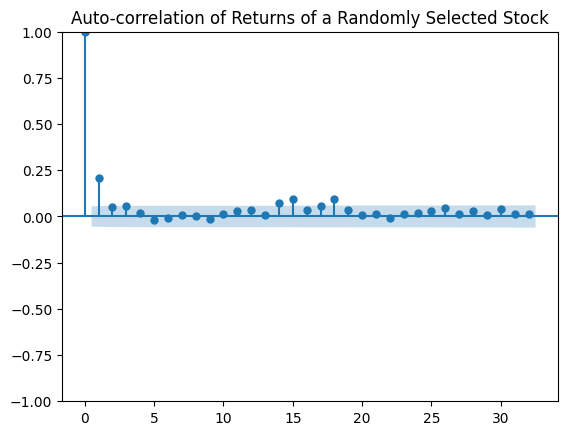

In [ ]:
plot_acf(squared_data)
plt.title("Auto-correlation of Returns of a Randomly Selected Stock")
plt.plot()

[]

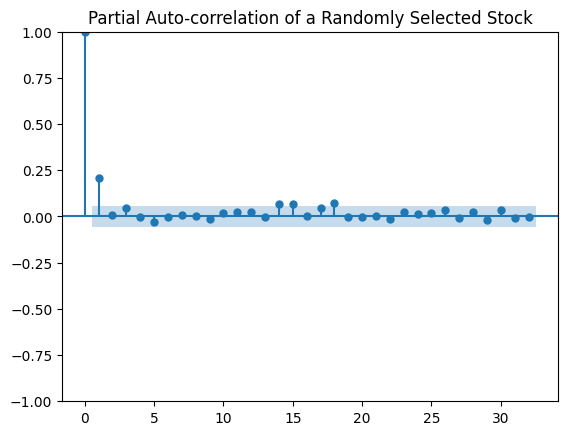

In [ ]:
plot_pacf(squared_data)
plt.title("Partial Auto-correlation of a Randomly Selected Stock")
plt.plot()

Based on the plots, we want find the optimal parameters between p = 1, 2, 3, ... , 15 or 20 and q = 0, 1, 2, ... , 15 or 20 for a total of 225-420 combinations. This is because the plots suggest possible auto-regressive relationships approximately up to these number of lags.

In [ ]:
p_testing = range(1, 15) #Range of parameters we will cross-validate and grid-search. When we iterated the first time
q_testing = range(0, 15) #we realized we could decrease the range: too much iterations for most optimal parameters to be around (1, 0) or (2,0)

In [ ]:
GARCH_tuned_parameters = {}

for ticker in ticker_list:
  optimal_params = evaluate_GARCH_models(df, ticker, p_testing, q_testing)
  GARCH_tuned_parameters[ticker] = optimal_params

GARCH(1,0) RMSE=0.130 R^2=-14.716
GARCH(2,0) RMSE=0.128 R^2=-14.319
Best AAPL GARCH = (2, 0) RMSE = 0.128 R^2 = -14.319
GARCH(1,0) RMSE=0.053 R^2=-5.099
Best ABCB GARCH = (1, 0) RMSE = 0.053 R^2 = -5.099
GARCH(1,0) RMSE=0.126 R^2=-12.874
GARCH(1,1) RMSE=0.124 R^2=-12.650
GARCH(1,2) RMSE=0.124 R^2=-12.650
Best ADBE GARCH = (1, 2) RMSE = 0.124 R^2 = -12.650
GARCH(1,0) RMSE=0.134 R^2=-13.627
Best ADI GARCH = (1, 0) RMSE = 0.134 R^2 = -13.627
GARCH(1,0) RMSE=0.030 R^2=-2.982
GARCH(2,0) RMSE=0.030 R^2=-2.980
Best ADP GARCH = (2, 0) RMSE = 0.030 R^2 = -2.980
GARCH(1,0) RMSE=0.134 R^2=-14.199
Best ADSK GARCH = (1, 0) RMSE = 0.134 R^2 = -14.199
GARCH(1,0) RMSE=0.014 R^2=-1.117
GARCH(2,0) RMSE=0.014 R^2=-1.115
Best AEP GARCH = (2, 0) RMSE = 0.014 R^2 = -1.115
GARCH(1,0) RMSE=0.140 R^2=-13.495
GARCH(1,1) RMSE=0.139 R^2=-13.262
GARCH(3,1) RMSE=0.139 R^2=-13.260
Best AMAT GARCH = (3, 1) RMSE = 0.139 R^2 = -13.260
GARCH(1,0) RMSE=0.159 R^2=-20.865
Best AMD GARCH = (1, 0) RMSE = 0.159 R^2 = -20.865


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best AMGN GARCH = (1, 0) RMSE = 0.065 R^2 = -7.399
GARCH(1,0) RMSE=0.078 R^2=-8.826
Best AUB GARCH = (1, 0) RMSE = 0.078 R^2 = -8.826
GARCH(1,0) RMSE=0.034 R^2=-3.329
Best AZN GARCH = (1, 0) RMSE = 0.034 R^2 = -3.329
GARCH(1,0) RMSE=0.043 R^2=-4.192
Best BANF GARCH = (1, 0) RMSE = 0.043 R^2 = -4.192
GARCH(1,0) RMSE=0.216 R^2=-22.646
GARCH(1,1) RMSE=0.215 R^2=-22.418
GARCH(1,2) RMSE=0.215 R^2=-22.356
GARCH(1,3) RMSE=0.211 R^2=-21.683
GARCH(6,1) RMSE=0.207 R^2=-21.090
Best BIIB GARCH = (6, 1) RMSE = 0.207 R^2 = -21.090
GARCH(1,0) RMSE=0.085 R^2=-14.532


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univa

Best BKR GARCH = (1, 0) RMSE = 0.085 R^2 = -14.532
GARCH(1,0) RMSE=0.088 R^2=-12.019
GARCH(1,1) RMSE=0.085 R^2=-11.052
GARCH(1,2) RMSE=0.083 R^2=-10.426
GARCH(1,3) RMSE=0.080 R^2=-9.473
GARCH(1,4) RMSE=0.080 R^2=-9.461
GARCH(4,6) RMSE=0.079 R^2=-9.445
GARCH(8,7) RMSE=0.079 R^2=-9.444
GARCH(9,6) RMSE=0.079 R^2=-9.443
GARCH(9,7) RMSE=0.079 R^2=-9.442
GARCH(11,7) RMSE=0.079 R^2=-9.442
Best BOKF GARCH = (11, 7) RMSE = 0.079 R^2 = -9.442
GARCH(1,0) RMSE=0.033 R^2=-6.714


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(2,0) RMSE=0.033 R^2=-6.597


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univa

Best BPOP GARCH = (2, 0) RMSE = 0.033 R^2 = -6.597
GARCH(1,0) RMSE=0.299 R^2=-65.337
GARCH(1,1) RMSE=0.289 R^2=-64.316
GARCH(2,1) RMSE=0.289 R^2=-64.167
GARCH(3,0) RMSE=0.260 R^2=-48.874


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best CACC GARCH = (3, 0) RMSE = 0.260 R^2 = -48.874
GARCH(1,0) RMSE=0.075 R^2=-9.638
Best CATY GARCH = (1, 0) RMSE = 0.075 R^2 = -9.638
GARCH(1,0) RMSE=0.023 R^2=-2.160
Best CBSH GARCH = (1, 0) RMSE = 0.023 R^2 = -2.160
GARCH(1,0) RMSE=0.055 R^2=-6.318
Best CCEP GARCH = (1, 0) RMSE = 0.055 R^2 = -6.318
GARCH(1,0) RMSE=0.150 R^2=-17.299
Best CDNS GARCH = (1, 0) RMSE = 0.150 R^2 = -17.299
GARCH(1,0) RMSE=0.072 R^2=-29.525
Best CINF GARCH = (1, 0) RMSE = 0.072 R^2 = -29.525
GARCH(1,0) RMSE=0.071 R^2=-8.989
Best CMCSA GARCH = (1, 0) RMSE = 0.071 R^2 = -8.989
GARCH(1,0) RMSE=0.081 R^2=-8.473
GARCH(1,3) RMSE=0.081 R^2=-8.422
GARCH(1,4) RMSE=0.081 R^2=-8.263
GARCH(1,6) RMSE=0.079 R^2=-7.986
GARCH(1,10) RMSE=0.079 R^2=-7.893
GARCH(1,11) RMSE=0.079 R^2=-7.871
GARCH(1,12) RMSE=0.078 R^2=-7.565
GARCH(1,13) RMSE=0.078 R^2=-7.565
GARCH(1,14) RMSE=0.078 R^2=-7.554
GARCH(8,14) RMSE=0.077 R^2=-7.498
Best COLB GARCH = (8, 14) RMSE = 0.077 R^2 = -7.498
GARCH(1,0) RMSE=0.058 R^2=-5.652
GARCH(1,1) RMSE=0.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/d

Best FRME GARCH = (1, 0) RMSE = 0.047 R^2 = -4.960
GARCH(1,0) RMSE=0.041 R^2=-3.944
GARCH(1,3) RMSE=0.041 R^2=-3.910
GARCH(1,4) RMSE=0.041 R^2=-3.868
GARCH(1,6) RMSE=0.041 R^2=-3.864
GARCH(1,7) RMSE=0.041 R^2=-3.852
Best FULT GARCH = (1, 7) RMSE = 0.041 R^2 = -3.852
GARCH(1,0) RMSE=0.079 R^2=-8.185
Best GBCI GARCH = (1, 0) RMSE = 0.079 R^2 = -8.185
GARCH(1,0) RMSE=0.173 R^2=-18.269
Best GILD GARCH = (1, 0) RMSE = 0.173 R^2 = -18.269
GARCH(1,0) RMSE=0.043 R^2=-7.173


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best HBAN GARCH = (1, 0) RMSE = 0.043 R^2 = -7.173
GARCH(1,0) RMSE=0.039 R^2=-4.116
Best HON GARCH = (1, 0) RMSE = 0.039 R^2 = -4.116
GARCH(1,0) RMSE=0.042 R^2=-4.192
Best HWC GARCH = (1, 0) RMSE = 0.042 R^2 = -4.192
GARCH(1,0) RMSE=0.158 R^2=-21.950
GARCH(3,0) RMSE=0.158 R^2=-21.901


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

Best IDXX GARCH = (3, 0) RMSE = 0.158 R^2 = -21.901
GARCH(1,0) RMSE=0.067 R^2=-6.347
GARCH(7,0) RMSE=0.067 R^2=-6.344
GARCH(8,0) RMSE=0.067 R^2=-6.326
GARCH(10,0) RMSE=0.067 R^2=-6.325
GARCH(11,0) RMSE=0.067 R^2=-6.321
GARCH(12,0) RMSE=0.067 R^2=-6.321
Best INTC GARCH = (12, 0) RMSE = 0.067 R^2 = -6.321
GARCH(1,0) RMSE=0.184 R^2=-21.203
Best INTU GARCH = (1, 0) RMSE = 0.184 R^2 = -21.203
GARCH(1,0) RMSE=0.192 R^2=-19.655
Best KLAC GARCH = (1, 0) RMSE = 0.192 R^2 = -19.655
GARCH(1,0) RMSE=0.043 R^2=-4.217
Best LIN GARCH = (1, 0) RMSE = 0.043 R^2 = -4.217
GARCH(1,0) RMSE=0.222 R^2=-26.638
Best LRCX GARCH = (1, 0) RMSE = 0.222 R^2 = -26.638
GARCH(1,0) RMSE=0.042 R^2=-5.232
Best MAR GARCH = (1, 0) RMSE = 0.042 R^2 = -5.232
GARCH(1,0) RMSE=0.168 R^2=-17.836
GARCH(1,3) RMSE=0.168 R^2=-17.780
GARCH(1,6) RMSE=0.167 R^2=-17.566
GARCH(1,7) RMSE=0.167 R^2=-17.511
GARCH(1,8) RMSE=0.167 R^2=-17.498
GARCH(1,9) RMSE=0.166 R^2=-17.357
GARCH(1,14) RMSE=0.164 R^2=-16.958
Best MCHP GARCH = (1, 14) RMSE =

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best ONB GARCH = (1, 0) RMSE = 0.019 R^2 = -3.806
GARCH(1,0) RMSE=0.059 R^2=-9.518
Best ORLY GARCH = (1, 0) RMSE = 0.059 R^2 = -9.518
GARCH(1,0) RMSE=0.081 R^2=-8.370
Best PAYX GARCH = (1, 0) RMSE = 0.081 R^2 = -8.370
GARCH(1,0) RMSE=0.072 R^2=-9.250
GARCH(3,0) RMSE=0.072 R^2=-9.242
Best PCAR GARCH = (3, 0) RMSE = 0.072 R^2 = -9.242
GARCH(1,0) RMSE=0.043 R^2=-5.079
Best PEP GARCH = (1, 0) RMSE = 0.043 R^2 = -5.079
GARCH(1,0) RMSE=0.174 R^2=-21.214
GARCH(2,0) RMSE=0.174 R^2=-21.062
Best QCOM GARCH = (2, 0) RMSE = 0.174 R^2 = -21.062
GARCH(1,0) RMSE=0.271 R^2=-32.185
GARCH(1,1) RMSE=0.265 R^2=-30.461
GARCH(2,1) RMSE=0.263 R^2=-30.130
Best REGN GARCH = (2, 1) RMSE = 0.263 R^2 = -30.130
GARCH(1,0) RMSE=0.040 R^2=-4.262
GARCH(1,1) RMSE=0.038 R^2=-3.844
GARCH(1,2) RMSE=0.038 R^2=-3.669
GARCH(1,3) RMSE=0.037 R^2=-3.522
GARCH(1,5) RMSE=0.037 R^2=-3.282
GARCH(1,9) RMSE=0.036 R^2=-3.162
GARCH(1,10) RMSE=0.035 R^2=-2.766
GARCH(1,13) RMSE=0.033 R^2=-2.349
GARCH(1,14) RMSE=0.033 R^2=-2.349
Best RNS

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

GARCH(8,10) RMSE=0.075 R^2=-8.697


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(9,10) RMSE=0.073 R^2=-8.208


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

Best SASR GARCH = (9, 10) RMSE = 0.073 R^2 = -8.208
GARCH(1,0) RMSE=0.032 R^2=-2.989
Best SBCF GARCH = (1, 0) RMSE = 0.032 R^2 = -2.989
GARCH(1,0) RMSE=0.107 R^2=-12.024
GARCH(13,2) RMSE=0.107 R^2=-11.466
GARCH(14,1) RMSE=0.106 R^2=-11.241
Best SBUX GARCH = (14, 1) RMSE = 0.106 R^2 = -11.241
GARCH(1,0) RMSE=0.041 R^2=-4.910
Best SFNC GARCH = (1, 0) RMSE = 0.041 R^2 = -4.910
GARCH(1,0) RMSE=0.039 R^2=-4.923
GARCH(1,1) RMSE=0.038 R^2=-4.580
GARCH(1,2) RMSE=0.035 R^2=-3.560
GARCH(1,3) RMSE=0.035 R^2=-3.506
GARCH(2,3) RMSE=0.035 R^2=-3.453
GARCH(2,5) RMSE=0.034 R^2=-3.426
GARCH(3,14) RMSE=0.034 R^2=-3.298
Best SIGI GARCH = (3, 14) RMSE = 0.034 R^2 = -3.298
GARCH(1,0) RMSE=0.646 R^2=-123.849


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best SIRI GARCH = (1, 0) RMSE = 0.646 R^2 = -123.849
GARCH(1,0) RMSE=0.047 R^2=-5.313
GARCH(1,1) RMSE=0.046 R^2=-4.958
GARCH(1,2) RMSE=0.044 R^2=-4.570
GARCH(1,3) RMSE=0.044 R^2=-4.535
Best SLM GARCH = (1, 3) RMSE = 0.044 R^2 = -4.535
GARCH(1,0) RMSE=0.131 R^2=-13.028
GARCH(1,1) RMSE=0.130 R^2=-12.825
GARCH(1,4) RMSE=0.130 R^2=-12.728
Best SNPS GARCH = (1, 4) RMSE = 0.130 R^2 = -12.728
GARCH(1,0) RMSE=0.052 R^2=-6.692
GARCH(1,4) RMSE=0.051 R^2=-6.281
GARCH(1,5) RMSE=0.051 R^2=-6.245
Best TRMK GARCH = (1, 5) RMSE = 0.051 R^2 = -6.245
GARCH(1,0) RMSE=0.091 R^2=-9.814
GARCH(1,1) RMSE=0.089 R^2=-9.389
GARCH(2,1) RMSE=0.089 R^2=-9.385
GARCH(2,4) RMSE=0.089 R^2=-9.327
GARCH(3,4) RMSE=0.089 R^2=-9.325
GARCH(3,5) RMSE=0.089 R^2=-9.300
GARCH(4,4) RMSE=0.089 R^2=-9.295
GARCH(5,5) RMSE=0.089 R^2=-9.199
GARCH(5,6) RMSE=0.089 R^2=-9.195
Best TROW GARCH = (5, 6) RMSE = 0.089 R^2 = -9.195
GARCH(1,0) RMSE=0.098 R^2=-9.523
Best TXN GARCH = (1, 0) RMSE = 0.098 R^2 = -9.523
GARCH(1,0) RMSE=0.043 R^2=-6.8

In [ ]:
GARCH_tuned_parameters

{'AAPL': (2, 0),
 'ABCB': (1, 0),
 'ADBE': (1, 2),
 'ADI': (1, 0),
 'ADP': (2, 0),
 'ADSK': (1, 0),
 'AEP': (2, 0),
 'AMAT': (3, 1),
 'AMD': (1, 0),
 'AMGN': (1, 0),
 'AUB': (1, 0),
 'AZN': (1, 0),
 'BANF': (1, 0),
 'BIIB': (6, 1),
 'BKR': (1, 0),
 'BOKF': (11, 7),
 'BPOP': (2, 0),
 'CACC': (3, 0),
 'CATY': (1, 0),
 'CBSH': (1, 0),
 'CCEP': (1, 0),
 'CDNS': (1, 0),
 'CINF': (1, 0),
 'CMCSA': (1, 0),
 'COLB': (8, 14),
 'COST': (11, 14),
 'CPRT': (1, 0),
 'CSCO': (12, 13),
 'CSX': (1, 0),
 'CTAS': (1, 0),
 'CVBF': (1, 0),
 'EA': (1, 0),
 'EXC': (1, 0),
 'FAST': (1, 0),
 'FCFS': (1, 0),
 'FCNCA': (1, 0),
 'FFBC': (1, 0),
 'FFIN': (1, 10),
 'FITB': (1, 0),
 'FRME': (1, 0),
 'FULT': (1, 7),
 'GBCI': (1, 0),
 'GILD': (1, 0),
 'HBAN': (1, 0),
 'HON': (1, 0),
 'HWC': (1, 0),
 'IDXX': (3, 0),
 'INTC': (12, 0),
 'INTU': (1, 0),
 'KLAC': (1, 0),
 'LIN': (1, 0),
 'LRCX': (1, 0),
 'MAR': (1, 0),
 'MCHP': (1, 14),
 'MNST': (2, 2),
 'MSFT': (1, 1),
 'MU': (3, 0),
 'NTRS': (1, 0),
 'ODFL': (1, 0),
 'O

## 2.3 Optimized Parameters for Prophet and GARCH

We create these Dataframes so that we do not need to run the cross validation and the grid search again. The computational time is too much.

In [ ]:
GARCH_params = pd.DataFrame.from_dict(GARCH_tuned_parameters)

In [ ]:
GARCH_params.to_csv("/content/drive/MyDrive/Cleaned_Data/GARCH_params.csv", index = True)

In [ ]:
Prophet_params = pd.DataFrame.from_dict(tuned_params_stocks)

In [ ]:
Prophet_params.to_csv("/content/drive/MyDrive/Cleaned_Data/Prophet_params.csv", index = True)

In [ ]:
GARCH_parameters = pd.read_csv("/content/drive/MyDrive/Cleaned_Data/GARCH_params.csv", index_col = False)
GARCH_parameters.index.rename("Parameter", inplace = True)
GARCH_parameters = GARCH_parameters.drop("Unnamed: 0", axis = 1)
GARCH_parameters.rename(index = {0 : "p", 1: "q"}, inplace = True)
GARCH_parameters.head()

,AAPL,ABCB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,UMBF,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,XEL,ZION
Parameter,,,,,,,,,,,,,,,,,,,,,
p,2,1,1,1,2,1,2,3,1,1,...,1,4,1,1,1,1,1,1,6,1
q,0,0,2,0,0,0,0,1,0,0,...,6,0,0,0,0,0,0,0,6,0


In [ ]:
Prophet_parameters = pd.read_csv("/content/drive/MyDrive/Cleaned_Data/Prophet_params.csv", index_col = False)
Prophet_parameters.index.rename("Parameter", inplace = True)
Prophet_parameters = Prophet_parameters.drop("Unnamed: 0", axis = 1)
Prophet_parameters.rename(index = {0 : "Changepoint_prior_scale"}, inplace = True)
Prophet_parameters.head()

,AAPL,ABCB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,UMBF,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,XEL,ZION
Parameter,,,,,,,,,,,,,,,,,,,,,
Changepoint_prior_scale,0.01,0.5,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,...,0.01,0.01,0.5,0.01,0.01,0.01,0.01,0.01,0.01,0.01


## 2.4 Back Testing Strategies

In [ ]:
# Function to forecast returns using Facebook Prophet
def forecast_returns(returns_data):
    forecasted_returns_means = []
    for col in returns_data.columns[1:]:  # Exclude the date column
        # Prepare data for Prophet
        df = returns_data[['Date', col]].copy()
        df.columns = ['ds', 'y']
        df["ds"] = pd.to_datetime(df["ds"])

        found = False

        for i in range(0, len(Prophet_parameters.columns)):

          if col == Prophet_parameters.columns[i]:

            # Create and fit Prophet model
            model = Prophet(daily_seasonality=False, yearly_seasonality= True,
                          changepoint_prior_scale= Prophet_parameters.loc["Changepoint_prior_scale"][i], seasonality_prior_scale= 0.01 )
            with suppress_stdout_stderr():
              model.add_country_holidays(country_name="US")
              model.fit(df)

              # Make future dataframe for one year ahead
              future = model.make_future_dataframe(periods=365, include_history = False)

              # Forecast returns
              forecast = model.predict(future)

            # Extract forecasted returns for the next year
            forecast_next_year = forecast['yhat'].values

            # Calculate mean of forecasted returns
            forecasted_return_mean = forecast_next_year.mean()
            forecasted_returns_means.append(forecasted_return_mean)

            found = True

            break #Break out of the loop once the column is found and processed

    # Convert list to array
    forecasted_returns_means = np.array(forecasted_returns_means)

    # Annualize forecasted returns means
    annualized_forecasted_returns_means = np.power(1 + forecasted_returns_means, 252) - 1

    return annualized_forecasted_returns_means


# Function to forecast volatility using GARCH model
def forecast_volatility(returns_data):
    vol_forecasts = []
    for col in returns_data.columns[1:]:

      found = False

      for i in range(0, len(GARCH_parameters.columns)):

        if col == GARCH_parameters.columns[i]:

          # Fit GARCH model
          model = arch_model(returns_data[col] * 100, mean = "Constant", vol = "GARCH", p = int(GARCH_parameters.loc["p"][i]),
                           q = int(GARCH_parameters.loc["q"][i]), rescale= False)
          result = model.fit(disp='off')

          # Forecast one year ahead
          forecasts = result.forecast(horizon=252).variance.values[-1]

          # Calculate forecasted volatility for the next year (model returns variance, not std)
          forecasted_volatility_next_year = np.sqrt(forecasts) / 100  #Scaling and de-scaling to obtain results

          vol_forecasts.append(forecasted_volatility_next_year)

          break  # Break out of the loop once the column is found and processed

    # Convert list to array
    vol_forecasts = np.array(vol_forecasts)

    return vol_forecasts


# Function to forecast correlation matrix using rolling window
def forecast_correlation_matrix(returns_data):
    rolling_corr = returns_data.rolling(window=252).corr(numeric_only = True)

    # Extract correlation matrix for the last day of the year
    correlation_matrix_next_year = rolling_corr.dropna().iloc[-91:]  #Correlation matrix of the 111 stocks

    return correlation_matrix_next_year

In [ ]:
#Functions used before for the Classical Mean Variance backtesting

def portfolio_gross_return (r, w):
  "Expected return of the portfolio is the weighted average of returns of the assets composing it. Not adjusted for costs. Return as % of capital invested"

  if type(r) == type(df.iloc[1]):
    #We need to remove the date column
    r = r.drop(["Date"])
  else:
    pass
  #r represents the returns of each asset
  #w represents the weights that go to each asset

  return np.dot(r, w)

def portfolio_volatility (w, covar):
  "Portfolio volatility is the following matrix multiplication: w^T . covariance_matrix . w"
  return np.sqrt(np.dot(w.T, np.dot(covar, w)))

def adjusted_port_return (portfolio_gross_return, initial_weights,  desired_weights, transaction_rate):
  "Desired weights are those obtained from the optimization. Transaction rate represents the % of transactions (change in weights) that represent costs"
  #We think of transaction costs calculation as a % of returns derived from the rate of weight changes that represent costs
  # % adjusted return = % gross return - % transaction cost
  #                 = % gross return - (sum(transaction_rate * weight changes))
  # Recall that because we used the .pct_change() pandas function to calculate returns, all returns are percentage returns

  vector_transaction_costs = transaction_rate * np.abs(initial_weights - desired_weights)
  total_transaction_costs = np.sum(vector_transaction_costs)
  adjusted_return = portfolio_gross_return - total_transaction_costs

  return adjusted_return

#MVP Optimization Model
def minimum_variance_portfolio (covariance_matrix, initial_weights):
  "This optimization method will find the highest return possible that one can get with the minimum risk: we will minimize the portfolio volatility"
  num_assets = len(initial_weights)

  #Set the weight constraints: all of them should be between 0 and 1 because we are working with a no-short strategy
  bounds = Bounds(0, 1)

  #Sum of weights should also equal 1 (100% of our capital)
  constraint_matrix = np.ones((1, num_assets))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  #Calculate portfolio volatility (but we do this because the function "minimize" needs a function as input in the first argument, not a function call)
  def port_vol (initial_weights, covariance_matrix):
    port_vol = portfolio_volatility(initial_weights, covariance_matrix)
    return port_vol

  result = minimize(port_vol, initial_weights, args = (covariance_matrix), method = "trust-constr", constraints = linear_constraint, bounds = bounds)

  return result

  #Max Sharpe Ratio Optimization Model
def neg_sharpe_ratio(weights, covar_matrix, expected_returns):
  portfolio_vol = portfolio_volatility(weights, covar_matrix)
  portfolio_ret = portfolio_gross_return(expected_returns, weights)
  return -portfolio_ret / portfolio_vol  # negative value for minimization

def sharpe_ratio_max (weights, covar_matrix, expected_returns):

  num_stocks = len(weights)

  # All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
  bounds = Bounds(0, 1)

  # Set the constraint that the sum of weights equals 1.
  constraint_matrix = np.ones((1, num_stocks))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  def neg_sh (weights, covar_matrix, expected_returns):
    sh = neg_sharpe_ratio(weights, covar_matrix, expected_returns)
    return sh

  # Minimize the negative Sharpe ratio (to maximize Sharpe ratio) using 'trust-constr' method with constraints and bounds.
  res_sharpe = minimize(neg_sh, weights, args = (covar_matrix, expected_returns), method='trust-constr', constraints=linear_constraint, bounds=bounds)

  return res_sharpe

### 2.4.1 Maximum Sharpe Ratio Back Test

In [ ]:
# Function to backtest the Max-Sharpe optimization strategy with annual rebalancing
def backtest_Max_Sharpe_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns[1:])       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if (day % rebalancing_period == 0 and day > 1262) or day == 1263:     #We start re-balancing from the 2000s onwards. Before that, data is used for training (the same data we used for cross-validation and grid search)

            # Forecast returns for the next year
            annualized_forecast_next_year = forecast_returns(returns.iloc[:day])

            # Forecast volatility for the next year
            forecasted_volatility_next_year = forecast_volatility(returns.iloc[:day])

            # Forecast correlation matrix for the next year
            correlation_matrix_next_year = forecast_correlation_matrix(returns.iloc[:day])

            # Check shapes before multiplication
            print(f"Shape of forecasted_volatility_next_year: {forecasted_volatility_next_year.shape}")
            print(f"Shape of correlation_matrix_next_year: {correlation_matrix_next_year.shape}")

            # Calculate covariance matrix using the forecasted volatility and correlation matrix
            forecasted_covariance_matrix_next_year = np.matmul(np.matmul(np.diag(forecasted_volatility_next_year), correlation_matrix_next_year), np.diag(forecasted_volatility_next_year))
            forecasted_covariance_matrix_next_year = forecasted_covariance_matrix_next_year * 252    #Simple Annualizing method

            # Calculate Max Sharpe portfolio
            Max_Sharpe = sharpe_ratio_max(previous_weights, forecasted_covariance_matrix_next_year, annualized_forecast_next_year)
            weights = Max_Sharpe.x

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Recalculate portfolio volatility (daily) and store value
            covariance_matrix = returns.iloc[:day].cov(numeric_only = True)
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights

        elif day > 1262 and day != 1263:  #From the 2000s we start with the equal weighting

            # Calculate portfolio returns(daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov(numeric_only = True)

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

        else:
            continue

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [ ]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
transaction_rate = 0.01

Max_shp_port_values, Max_shp_adjusted_returns, Max_shp_portfolio_volatilities = backtest_Max_Sharpe_strategy(df, transaction_rate)

Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)
Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Shape of forecasted_volatility_next_year: (91, 252)
Shape of correlation_matrix_next_year: (91, 91)


In [ ]:
Maxsharpe_returns_and_vol = pd.DataFrame({"Max Shp Portfolio Returns": Max_shp_adjusted_returns, "Max Shp Volatility": Max_shp_portfolio_volatilities })
Maxsharpe_returns_and_vol = Maxsharpe_returns_and_vol.dropna()
len(Maxsharpe_returns_and_vol)

5094

In [ ]:
Maxsharpe_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252)* (Maxsharpe_returns_and_vol["Max Shp Portfolio Returns"].rolling(252).mean() / Maxsharpe_returns_and_vol["Max Shp Volatility"].rolling(252).mean())
Maxsharpe_returns_and_vol.head()

,Max Shp Portfolio Returns,Max Shp Volatility,Rolling Sharpe Ratio
0,-0.026960,0.019430,NaN
1,-0.070019,0.019428,NaN
2,0.021426,0.019528,NaN
3,-0.019964,0.019527,NaN
4,0.066066,0.019530,NaN


### 2.4.2 Minimum Variance Back Test

In [ ]:
# Function to backtest the Max-Sharpe optimization strategy with annual rebalancing
def backtest_MVP_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns[1:])       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if (day % rebalancing_period == 0 and day > 1262) or day == 1263:     #We start re-balancing from 2002 onwards. Before that, data is used for training (the same data we used for cross-validation and grid search)

            # Forecast volatility for the next year (I only need to forecast volatility for the MVP Strategy)
            forecasted_volatility_next_year = forecast_volatility(returns.iloc[:day])

            # Forecast correlation matrix for the next year
            correlation_matrix_next_year = forecast_correlation_matrix(returns.iloc[:day])

            # Calculate covariance matrix using the forecasted volatility and correlation matrix
            forecasted_covariance_matrix_next_year = np.matmul(np.matmul(np.diag(forecasted_volatility_next_year), correlation_matrix_next_year), np.diag(forecasted_volatility_next_year))
            forecasted_covariance_matrix_next_year = forecasted_covariance_matrix_next_year * 252    #Simple Annualizing method

            # Calculate Max Sharpe portfolio
            MVP = minimum_variance_portfolio(forecasted_covariance_matrix_next_year, previous_weights)
            weights = MVP.x

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] *(1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Recalculate portfolio volatility (daily) and store value
            covariance_matrix = returns.iloc[:day].cov(numeric_only = True)
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights

        elif day > 1262 and day != 1263:   #From the 2000s we start with the equal weights

            # Calculate portfolio returns(daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] *(1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov(numeric_only = True)

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

        else:
            continue

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [ ]:
transaction_rate = 0.01

MVP_portfolio_values, MVP_adjusted_returns, MVP_portfolio_volatilities = backtest_MVP_strategy(df, transaction_rate)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
MVP_returns_and_vol = pd.DataFrame({"MVP Portfolio Returns": MVP_adjusted_returns, "MVP Volatility": MVP_portfolio_volatilities })
MVP_returns_and_vol = MVP_returns_and_vol.dropna()
len(MVP_returns_and_vol)

5094

In [ ]:
MVP_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252)* (MVP_returns_and_vol["MVP Portfolio Returns"].rolling(252).mean() / MVP_returns_and_vol["MVP Volatility"].rolling(252).mean())
MVP_returns_and_vol.head()

,MVP Portfolio Returns,MVP Volatility,Rolling Sharpe Ratio
0,-0.015784,0.009400,NaN
1,-0.035483,0.009408,NaN
2,0.009604,0.009461,NaN
3,-0.004024,0.009461,NaN
4,0.021897,0.009458,NaN


### 2.4.3 Equally-weighted (Benchmark) Back Test

In [ ]:
# Function to backtest the Max-Sharpe optimization strategy with annual rebalancing
def backtest_benchmark_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns[1:])       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    weights = np.ones(num_assets) / num_assets  # Equally weighted portfolio

    for day in range(num_days):

      if day >= 1263:   #We start after in-sample data.

          # Calculate portfolio returns (daily)
          portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

          #If there is no rebalancing, there are no transaction costs
          adjusted_return = portfolio_return

          # Store adjusted returns
          adjusted_returns.append(adjusted_return)

          # Update portfolio value
          portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

          # Store portfolio value
          portfolio_values.append(portfolio_value)

          #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
          covar_data = returns.iloc[:day]
          covar_matrix = covar_data.cov(numeric_only = True)

          # Recalculate portfolio volatility (daily) and store value
          portfolio_volatility_value = portfolio_volatility(weights, covar_matrix)
          portfolio_volatilities.append(portfolio_volatility_value)

      else:
          continue

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [ ]:
#We use the same transaction rate = 0.01 or 1% of transactions
transaction_rate = 0.01

benchmark_portfolio_values, benchmark_adjusted_returns, benchmark_portfolio_volatilities = backtest_benchmark_strategy(df, transaction_rate)

In [ ]:
benchmark_returns_and_vol = pd.DataFrame({"Benchmark Portfolio Returns": benchmark_adjusted_returns, "Benchmark Volatility": benchmark_portfolio_volatilities })
benchmark_returns_and_vol = benchmark_returns_and_vol.dropna()
len(benchmark_returns_and_vol)

5094

In [ ]:
benchmark_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252)* (benchmark_returns_and_vol["Benchmark Portfolio Returns"].rolling(252).mean() / benchmark_returns_and_vol["Benchmark Volatility"].rolling(252).mean())
benchmark_returns_and_vol.head()

,Benchmark Portfolio Returns,Benchmark Volatility,Rolling Sharpe Ratio
0,-0.015784,0.009400,NaN
1,-0.035483,0.009408,NaN
2,0.009604,0.009461,NaN
3,-0.004024,0.009461,NaN
4,0.021897,0.009458,NaN


### 2.4.5 Results and Comparison Plots

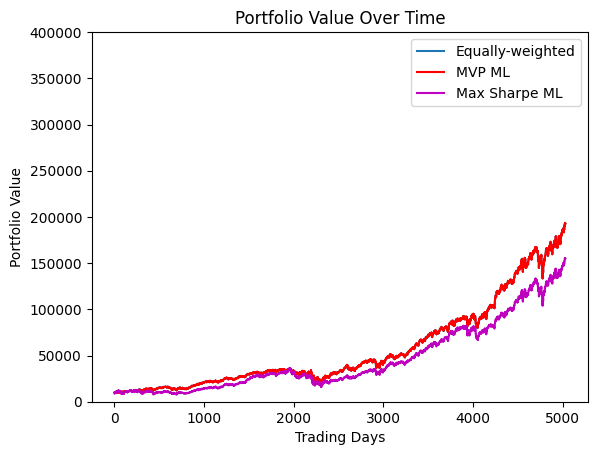

In [ ]:
#Again we exclude COVID times (up to the end of 2019)
plt.plot(benchmark_portfolio_values[0:5030], label = "Equally-weighted")
plt.plot(MVP_portfolio_values[0:5030], label = "MVP ML", color = "r")
plt.plot(Max_shp_port_values[0:5030], label = "Max Sharpe ML", color = "m")
plt.title("Portfolio Value Over Time")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value")
plt.ylim(0, 400000)
plt.legend()
plt.show()

In [ ]:
print(MVP_portfolio_values[5030])
print(Max_shp_port_values[5030])
print(benchmark_portfolio_values[5030])

192483.80336757997
154795.49707808445
192483.85127751212


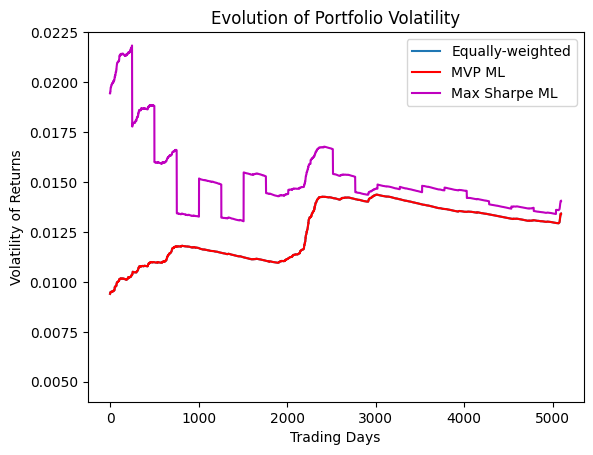

In [ ]:
plt.plot(benchmark_portfolio_volatilities, label = "Equally-weighted")
plt.plot(MVP_portfolio_volatilities, label = "MVP ML", color = "r")
plt.plot(Max_shp_portfolio_volatilities, label = "Max Sharpe ML", color = "m")
plt.title("Evolution of Portfolio Volatility")
plt.xlabel("Trading Days")
plt.ylabel("Volatility of Returns")
plt.ylim(0.004, 0.0225)
plt.legend()
plt.show()

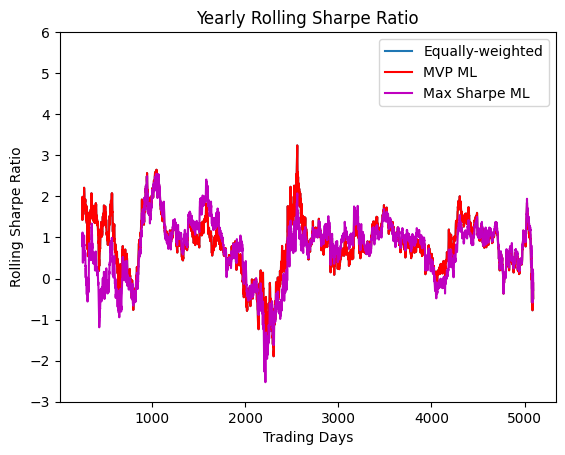

In [ ]:
plt.plot(benchmark_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "Equally-weighted")
plt.plot(MVP_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "MVP ML", color = "r")
plt.plot(Maxsharpe_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "Max Sharpe ML", color = "m")
plt.title("Yearly Rolling Sharpe Ratio")
plt.xlabel("Trading Days")
plt.ylabel("Rolling Sharpe Ratio")
plt.ylim(-3, 6)
plt.legend()
plt.show()